In [1]:
import torch
import torch.nn as nn
import timeit
import numpy as np
from tqdm import tqdm
import pandas as pd

import matplotlib.pyplot as plt

np.random.seed(1234)

In [2]:
class Net(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.linear1 = nn.Linear(layers[0], layers[1])
        self.linear2 = nn.Linear(layers[1], layers[2])

    def forward(self, x):
        x = self.linear1(x)
        x = torch.tanh(x)
        return self.linear2(x)

In [3]:
relative_err_x = []
relative_err_y = []

In [4]:
def calappx(model, q, realt, realData, N, NX, NVar):
    w = 1e-3
    M = 1000
    s = realt[1] / N
    intw = 0.005
    appx = torch.zeros([NX, NVar])
    graph_appx = torch.zeros([NX, NVar])
    gradq = np.zeros([NX, NVar])
    for xt in tqdm(range(1, NX + 1)):
        xy = model.forward(realData[0:(N * xt + 1), :])
        t = realt[N * xt + 1]
        sw = s * w
        k = np.zeros([N * xt, NVar])
        for ki in range(NVar):
            k[:, ki] = np.arange(0, N * xt, 1)
        k = torch.tensor(k, requires_grad=False)
        sumf0 = xy[:N * xt, :] * np.exp(k * s * intw) + xy[1:(N * xt + 1), :] * np.exp((k + 1) * s * intw)
        sumf1 = xy[:N * xt, :] * np.exp(k * sw) + xy[1:(N * xt + 1), :] * np.exp((k + 1) * sw)
        sumf0 = torch.sum(sumf0, dim=0) * s / 2
        sumf1 = torch.sum(sumf1, dim=0) * s / 2

        sumx = (w - intw) * (np.exp(-intw * t) * (np.power(intw, -q)) * sumf0 + np.exp(-w * t) * (
            np.power(w, -q)) * sumf1) / 2
        sumxq = -(w - intw) * (np.exp(-intw * t) * (np.power(intw, -q)) * np.log(intw) * sumf0.detach().numpy() + np.exp(
            -w * t) * (np.power(w, -q)) * np.log(w) * sumf1.detach().numpy()) / 2

        for j in range(2, M + 1):
            sumf0 = sumf1
            sumf1 = torch.zeros(NVar)
            sjw = sw * j
            sumf1 = xy[:N * xt, :] * np.exp(k * sjw) + xy[1:(N * xt + 1), :] * np.exp((k + 1) * sjw)
            #             for k in range(N * xt):
            #                 sumf1 = sumf1 + xy[k, :] * np.exp(k * sjw) + xy[(k + 1), :] * np.exp((k + 1) * sjw)
            sumf1 = torch.sum(sumf1, dim=0) * s / 2

            sumx = sumx + w * (np.exp(-j * w * t) * (np.power(j * w, -q)) * sumf0 +
                               np.exp(-(j + 1) * w * t) * (np.power((j + 1) * w, -q)) * sumf1) / 2
            sumxq = sumxq - w * (np.exp(-j * w * t) * (np.power(j * w, -q)) * np.log(j * w) * sumf0.detach().numpy() +
                                 np.exp(-(j + 1) * w * t) * (np.power((j + 1) * w, -q)) * np.log((j + 1) * w) * sumf1.detach().numpy()) / 2

        appx[xt - 1, :] = sumx * np.sin(np.pi * q) / np.pi + realData[0, 0:NVar]
        gradq[xt - 1, :] = sumx.detach().numpy() * np.cos(np.pi * q) + sumxq * np.sin(np.pi * q) / np.pi
        graph_appx[xt - 1, :] = sumx * np.sin(np.pi * q) / np.pi + realData[0, 0:NVar] + realData[(xt - 1) * N + 1, 0:NVar]

    grad4q = 2 * sum(sum(appx.detach().numpy() * gradq)) / NX
    
    actual_data = realData0[[i * N + 1 for i in range(NX)], :2]
    predicted_data = graph_appx.detach().numpy()
    
    relative_error = np.abs(actual_data - predicted_data) / np.abs(actual_data)
    re_x = relative_error[:, 0]
    re_y = relative_error[:, 1]
    
    sum_x = 0
    sum_y = 0
    
    for i in range(len(re_x)):
        sum_x = sum_x + re_x[i]
        sum_y = sum_y + re_y[i]
        
    avg_x = sum_x/len(re_x)
    avg_y = sum_y/len(re_y)
    
    
    relative_err_x.append(avg_x)
    relative_err_y.append(avg_y)
    
    
    plotNN_duffing(NX, 50, [realt[i * N] for i in range(NX)], realData0[[i * N + 1 for i in range(NX)], :], graph_appx.detach().numpy())  # realData0[[i*N+1 for i in range(50)],:])
    plt.show()

    return appx, grad4q

In [39]:
def plotNN_duffing(NX, testt, t, FX, learnedX):

    plt.figure(figsize = (13,6.5))
    plt.subplot(1, 2, 1)
    plt.plot(t, FX[:, 0], linewidth=2.8, color = "steelblue")
    plt.plot(t[:149], learnedX[:149, 0],linewidth=2.8, color = "firebrick", dashes = [6,2])
    plt.plot(t[-testt:], learnedX[-testt:, 0], linewidth=2.8, color = "peru", dashes = [6,2])
    plt.xlabel("t - Time", fontname='Times New Roman', fontsize=16)
    plt.ylabel("x - Change in Cartoid Artery's Internal Diameter", fontname='Times New Roman', fontsize=16)
    plt.title("Discovered Numerical Solution for State Variable x\n", fontname='Times New Roman', fontsize=16)
    
    plt.subplot(1, 2, 2)
    plt.plot(t, FX[:, 1], linewidth=2.8, color = "steelblue")
    plt.plot(t[:149], learnedX[:149, 1], linewidth=2.8, color = "firebrick", dashes = [6,2])
    plt.plot(t[-testt:], learnedX[-testt:, 1], linewidth=2.8, color = "peru", dashes = [6,2])
    plt.xlabel("t - Time", fontname='Times New Roman', fontsize=16)
    plt.ylabel("y - Change in Mean Artery Pressure", fontname='Times New Roman', fontsize=16)
    plt.title("Discovered Numerical Solution for State Variable y\n", fontname='Times New Roman', fontsize=16)
    
    plt.savefig(r'C:\Users\Admin\Desktop\Fmbv_04161.pdf')
    
    plt.figure(figsize = (10,7.5))
    plt.plot(FX[:, 0], FX[:, 1], linewidth=2.8, color = "steelblue")
    plt.plot(learnedX[:149, 0], learnedX[:149, 1], linewidth=2.8, color = "firebrick", dashes = [6,2])
    plt.plot(learnedX[-testt:, 0], learnedX[-testt:, 1], linewidth=2.8, color = "peru", dashes = [6,2])
    plt.xlabel("x - Change in Cartoid Artery's Internal Diameter", fontname='Times New Roman', fontsize=19)
    plt.ylabel("y - Change in Mean Artery Pressure", fontname='Times New Roman', fontsize=19)
    plt.title('2-Dimensional Phase Portrait for Discovered System\n', fontname='Times New Roman', fontsize=22)

    plt.savefig(r'C:\Users\Admin\Desktop\Fmbv_04162.pdf')

In [6]:
MBV_X = np.genfromtxt(r'C:\Users\Admin\Desktop\Real_X.csv', delimiter=',')
MBV_t = np.genfromtxt(r'C:\Users\Admin\Desktop\Real_t.csv', delimiter=',')

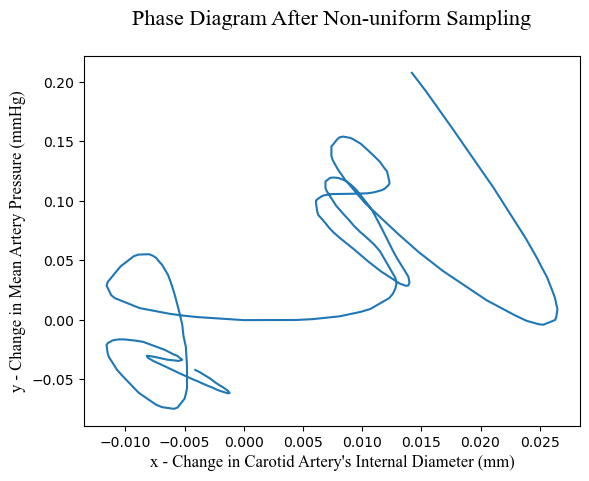

In [7]:
x_values = [point[0] for point in MBV_X]
y_values = [point[1] for point in MBV_X]

plt.plot(x_values, y_values, linestyle='-')
plt.xlabel("x - Change in Carotid Artery's Internal Diameter (mm)", fontname='Times New Roman', fontsize=12)
plt.ylabel('y - Change in Mean Artery Pressure (mmHg)', fontname='Times New Roman', fontsize=12)
plt.title('Phase Diagram After Non-uniform Sampling\n', fontname='Times New Roman', fontsize=16)
plt.show()

In [8]:
from sklearn.preprocessing import MinMaxScaler

x_series = pd.Series(x_values)
y_series = pd.Series(y_values)

scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_x = scaler.fit_transform(x_series.values.reshape(-1, 1))
scaled_y = scaler.fit_transform(y_series.values.reshape(-1, 1))

In [9]:
temp_X = []
for i in range(len(scaled_x)):
    temp_X.append([scaled_x[i], scaled_y[i]])

MBV_X_scaled = np.concatenate(temp_X).reshape(-1, 2)
MBV_X_scaled

array([[ 0.35433071,  1.        ],
       [ 0.41732283,  0.88955752],
       [ 0.52755906,  0.68141593],
       [ 0.71653543,  0.31610619],
       [ 0.85826772,  0.01734513],
       [ 0.91076115, -0.10584071],
       [ 0.93175853, -0.16176991],
       [ 0.95275591, -0.21274336],
       [ 0.97900262, -0.30265487],
       [ 0.98950131, -0.34159292],
       [ 0.99475066, -0.37628319],
       [ 1.        , -0.4060177 ],
       [ 0.99475066, -0.45415929],
       [ 0.98950131, -0.47115044],
       [ 0.93700787, -0.49946903],
       [ 0.9160105 , -0.4959292 ],
       [ 0.86351706, -0.47610619],
       [ 0.83727034, -0.45982301],
       [ 0.80577428, -0.43929204],
       [ 0.68503937, -0.35292035],
       [ 0.49081365, -0.1780531 ],
       [ 0.38582677, -0.06831858],
       [ 0.29658793,  0.03716814],
       [ 0.1496063 ,  0.22123894],
       [ 0.12335958,  0.26159292],
       [ 0.05511811,  0.36920354],
       [ 0.02362205,  0.43079646],
       [ 0.00262467,  0.48247788],
       [-0.00262467,

In [10]:
MBV_X_merged = np.column_stack((MBV_X_scaled, MBV_t))
print(MBV_X_merged[:5,:])

[[0.35433071 1.         0.        ]
 [0.41732283 0.88955752 0.5       ]
 [0.52755906 0.68141593 1.5       ]
 [0.71653543 0.31610619 3.5       ]
 [0.85826772 0.01734513 5.5       ]]


In [11]:
layers = [3, 256, 2]
NN = Net(layers)
realData0 = MBV_X_merged
realt = MBV_t
realData = realData0
#     realData, minx, maxx = minmaxscaler(realData0)

realData = torch.tensor(realData.astype(np.float32), requires_grad=True)
q = torch.load(r'C:\Users\Admin\Desktop\NN Discovery\code\q_value_min_duffing.pth')
print(q)

lossmin = np.Inf
q_value = []
NN.load_state_dict(torch.load(r'C:\Users\Admin\Desktop\NN Discovery\code\Frac_NN_alpha_min_duffing.pkl'))
NX = 199
NVar = 2
w = 1e-3
M = 1000
N = 1
t = 0.5
s = t / N
intw = 0.005
appx = torch.zeros([NX, NVar])
gradq = np.zeros([NX, NVar])

learning_rate = 0.05
optimizer_Adam = torch.optim.Adam(NN.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer_Adam, step_size=5000, gamma=0.9)

start_time = timeit.default_timer()

0.33625778410313184


In [12]:
losses = []

100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [01:27<00:00,  2.27it/s]


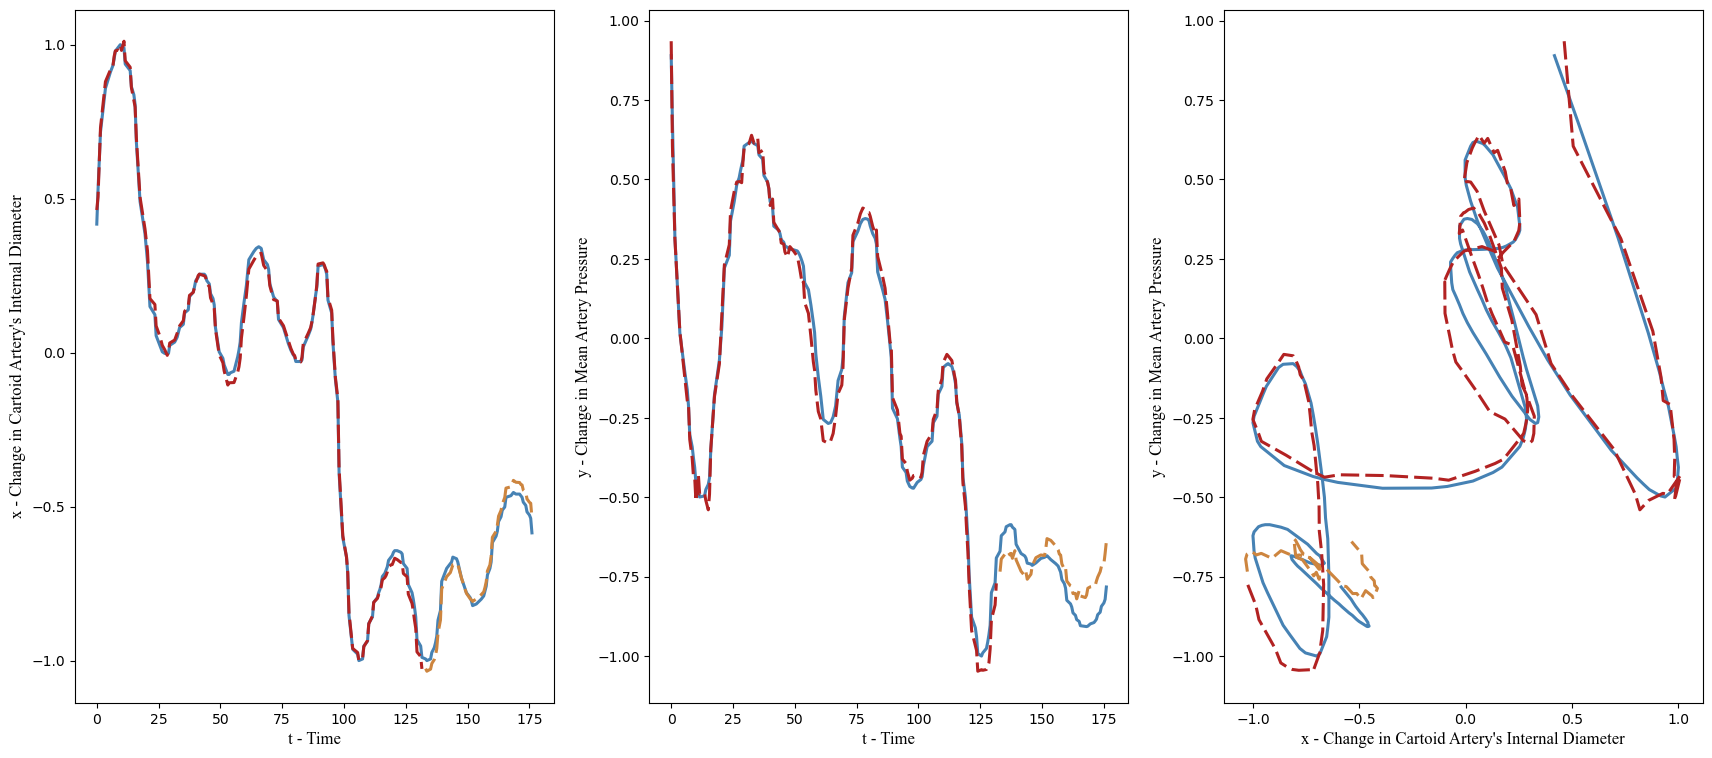

grad4q 0.08615697755062109
sIt: 0, Loss: 3.5643323790e-03, Time: 5551.73
0.05
0.3212281308732378


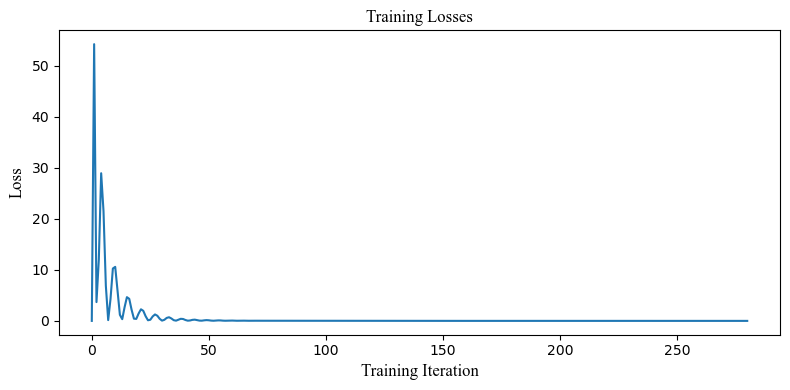

100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [01:27<00:00,  2.26it/s]


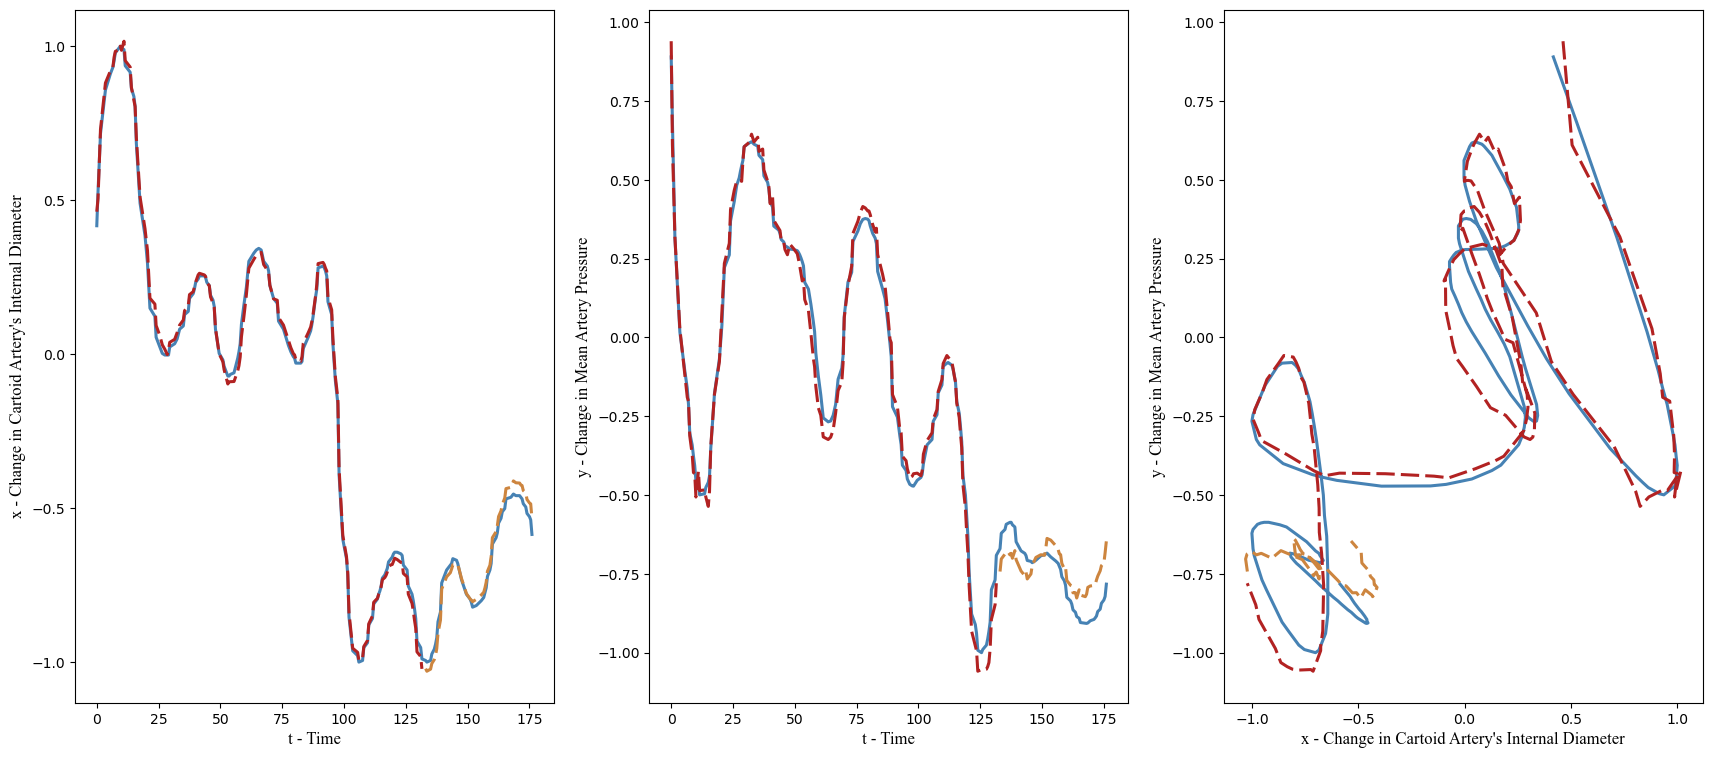

grad4q 0.06478890481460378
sIt: 1, Loss: 3.4788302146e-03, Time: 138.23
0.05
0.32058024182509176


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [01:26<00:00,  2.30it/s]


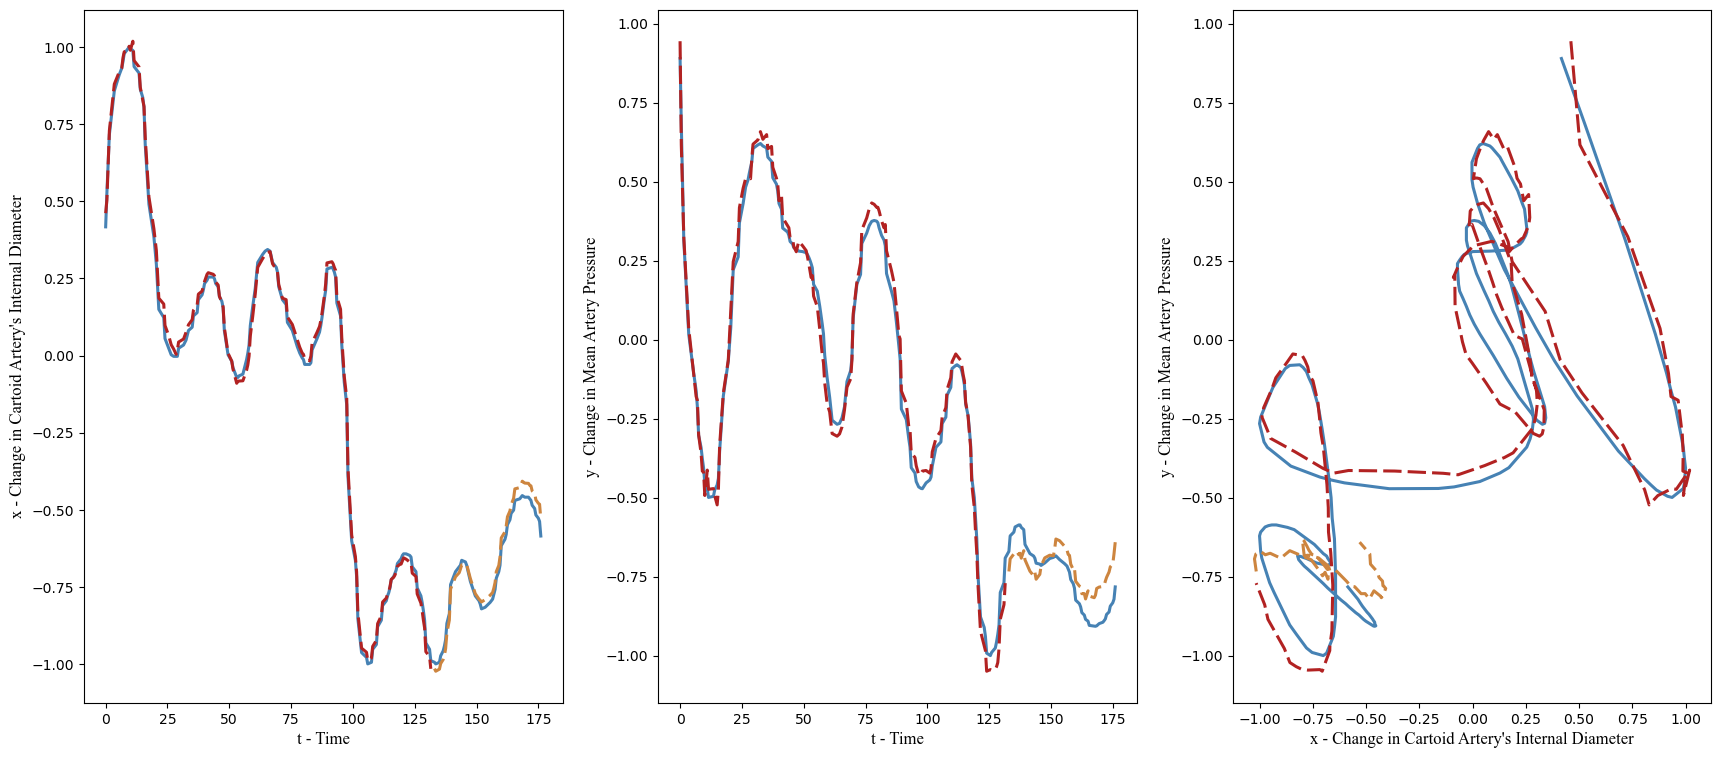

grad4q -0.07945823625734376
sIt: 2, Loss: 3.5319183953e-03, Time: 136.61
0.05
0.3213748241876652


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [01:29<00:00,  2.23it/s]


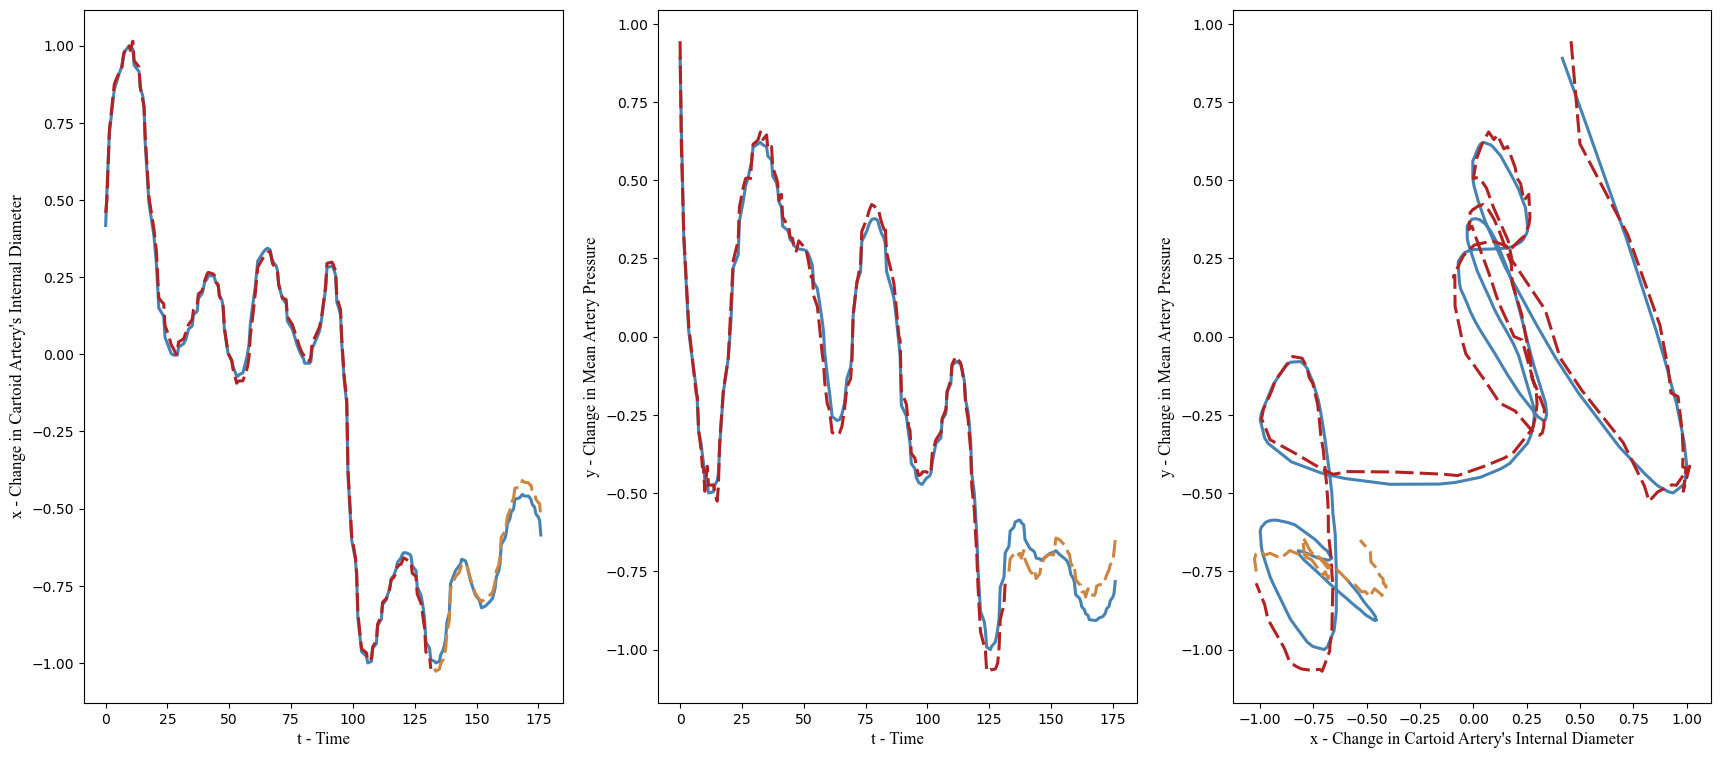

grad4q 0.03760643773135382
sIt: 3, Loss: 3.5167003516e-03, Time: 140.35
0.05
0.3209987598103517


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [01:26<00:00,  2.30it/s]


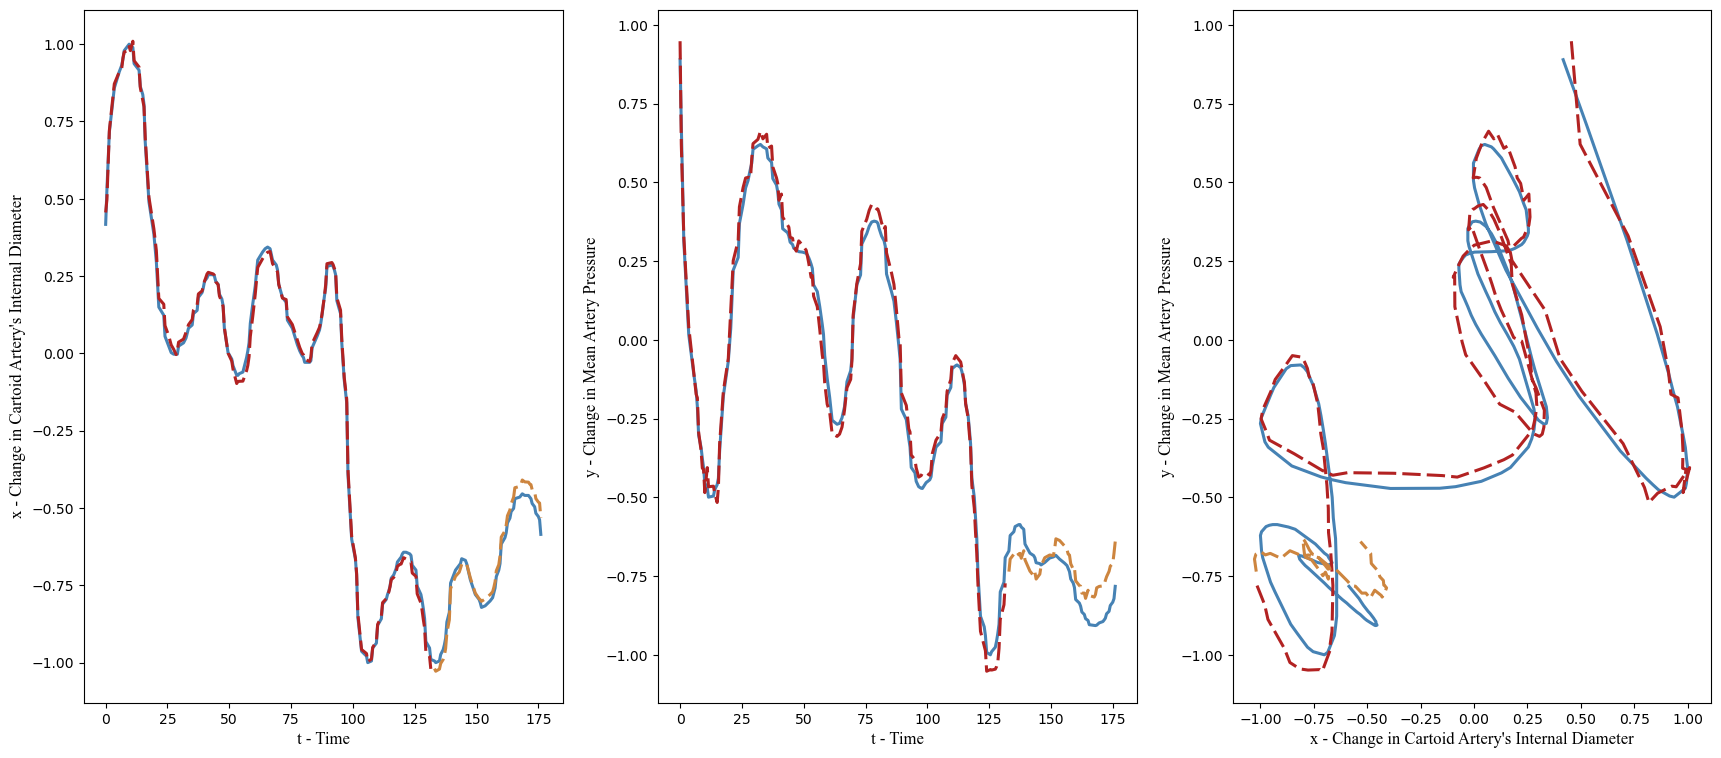

grad4q -0.05346410688346809
sIt: 4, Loss: 3.4677167423e-03, Time: 135.48
0.05
0.32153340087918636


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [01:27<00:00,  2.29it/s]


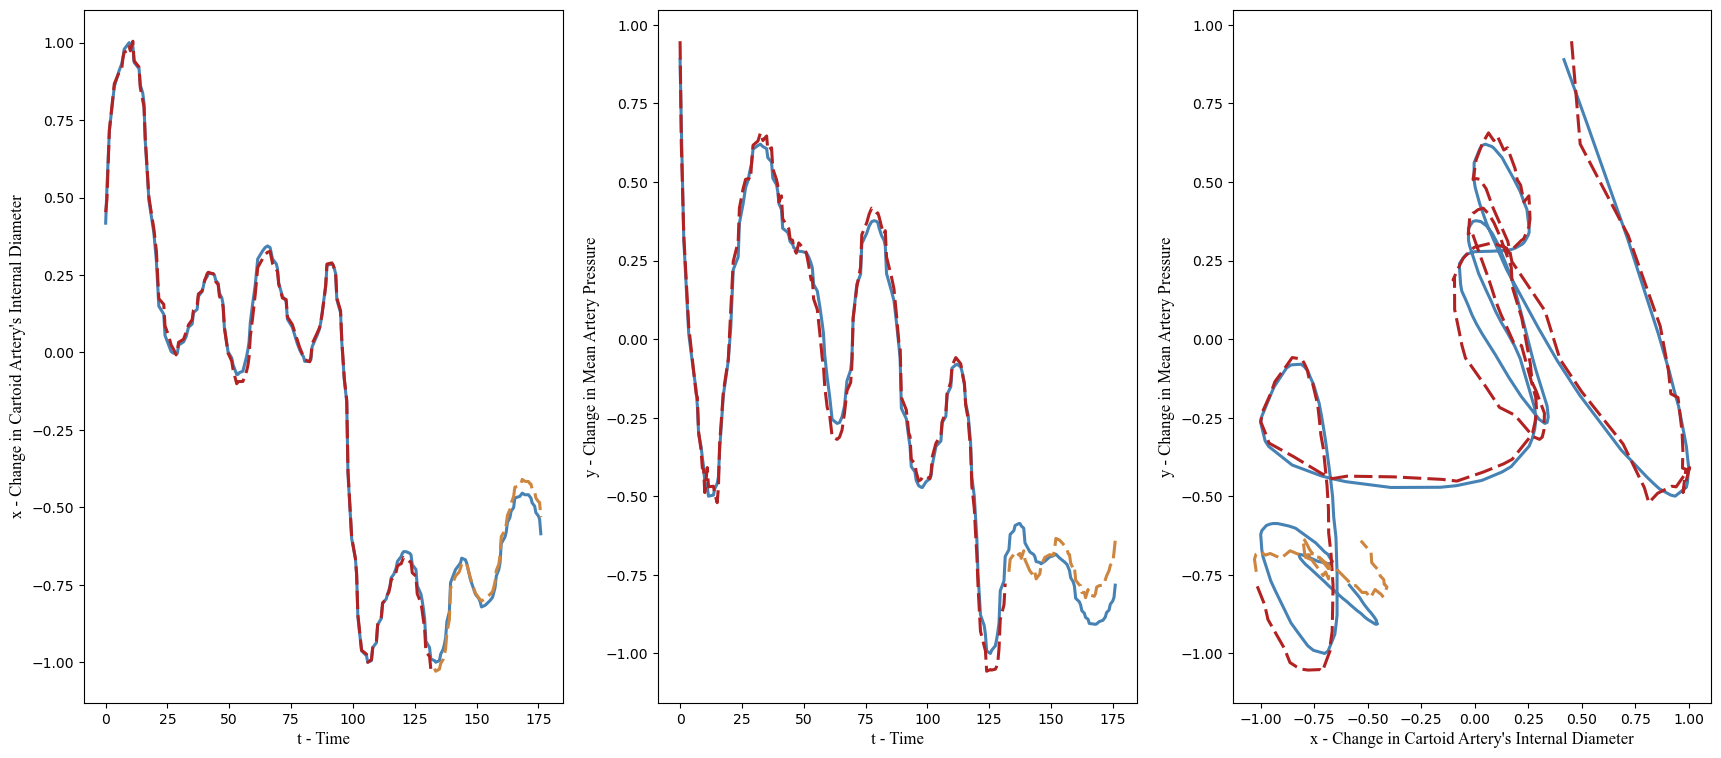

grad4q 0.028819508781483753
sIt: 5, Loss: 3.4250854515e-03, Time: 136.81
0.05
0.3212452057913715


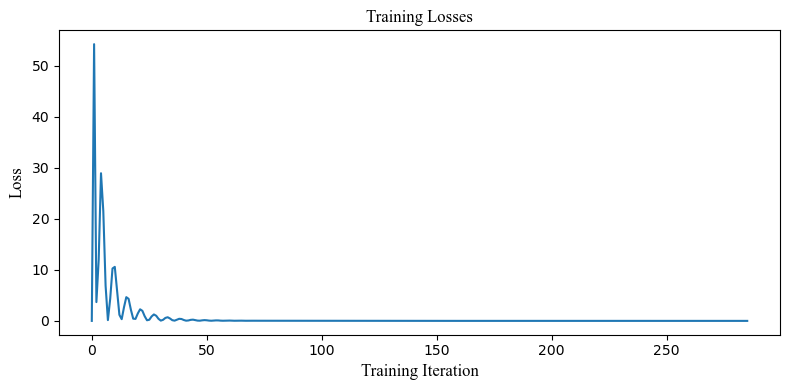

100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [01:27<00:00,  2.29it/s]


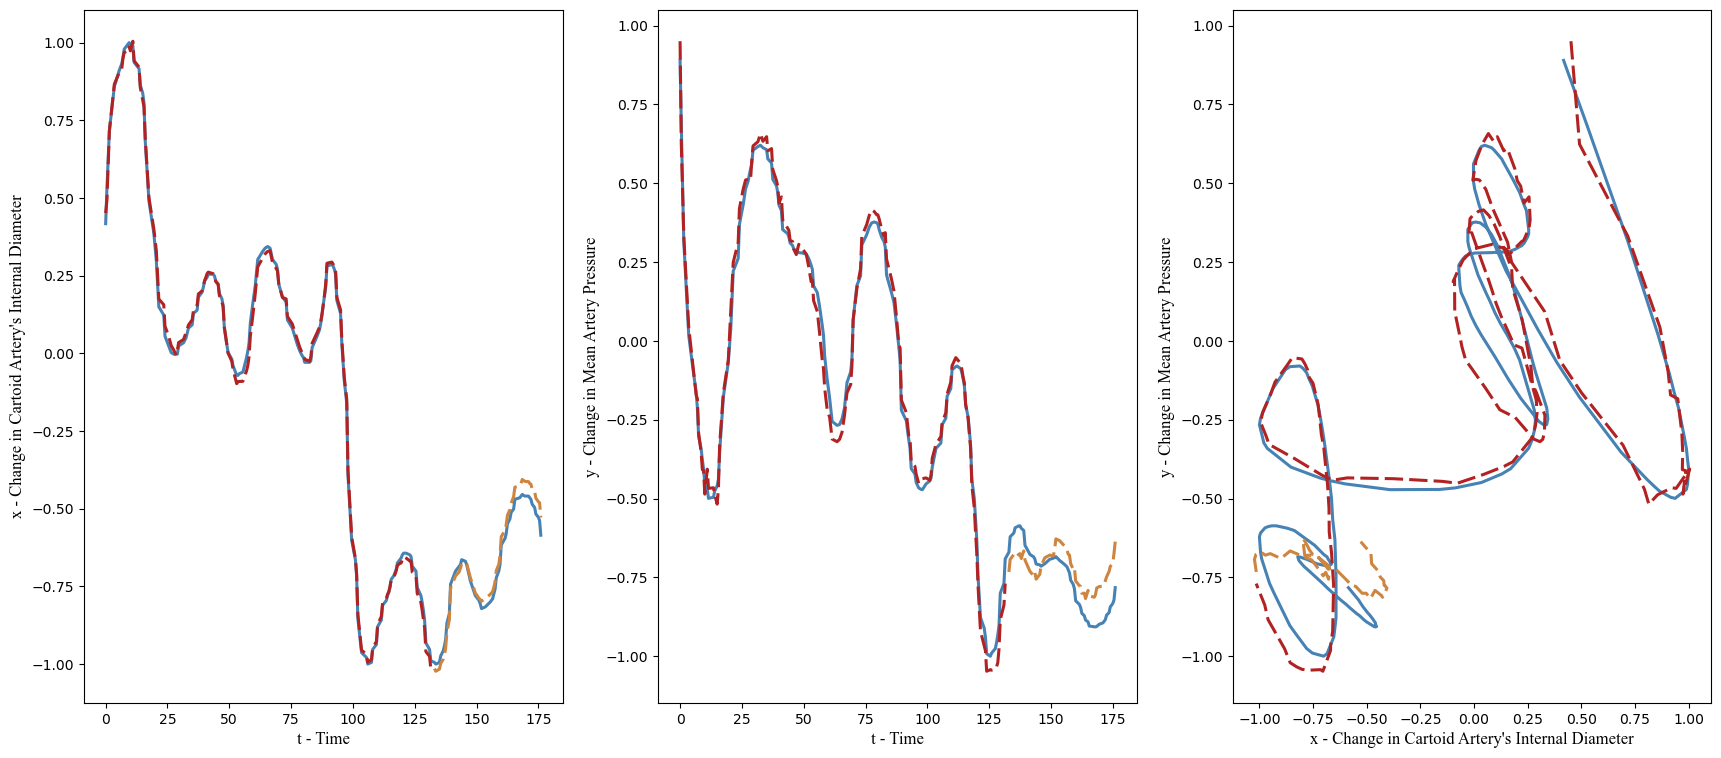

grad4q -0.010635605089596064
sIt: 6, Loss: 3.3958996646e-03, Time: 137.06
0.05
0.3213515618422675


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [01:27<00:00,  2.26it/s]


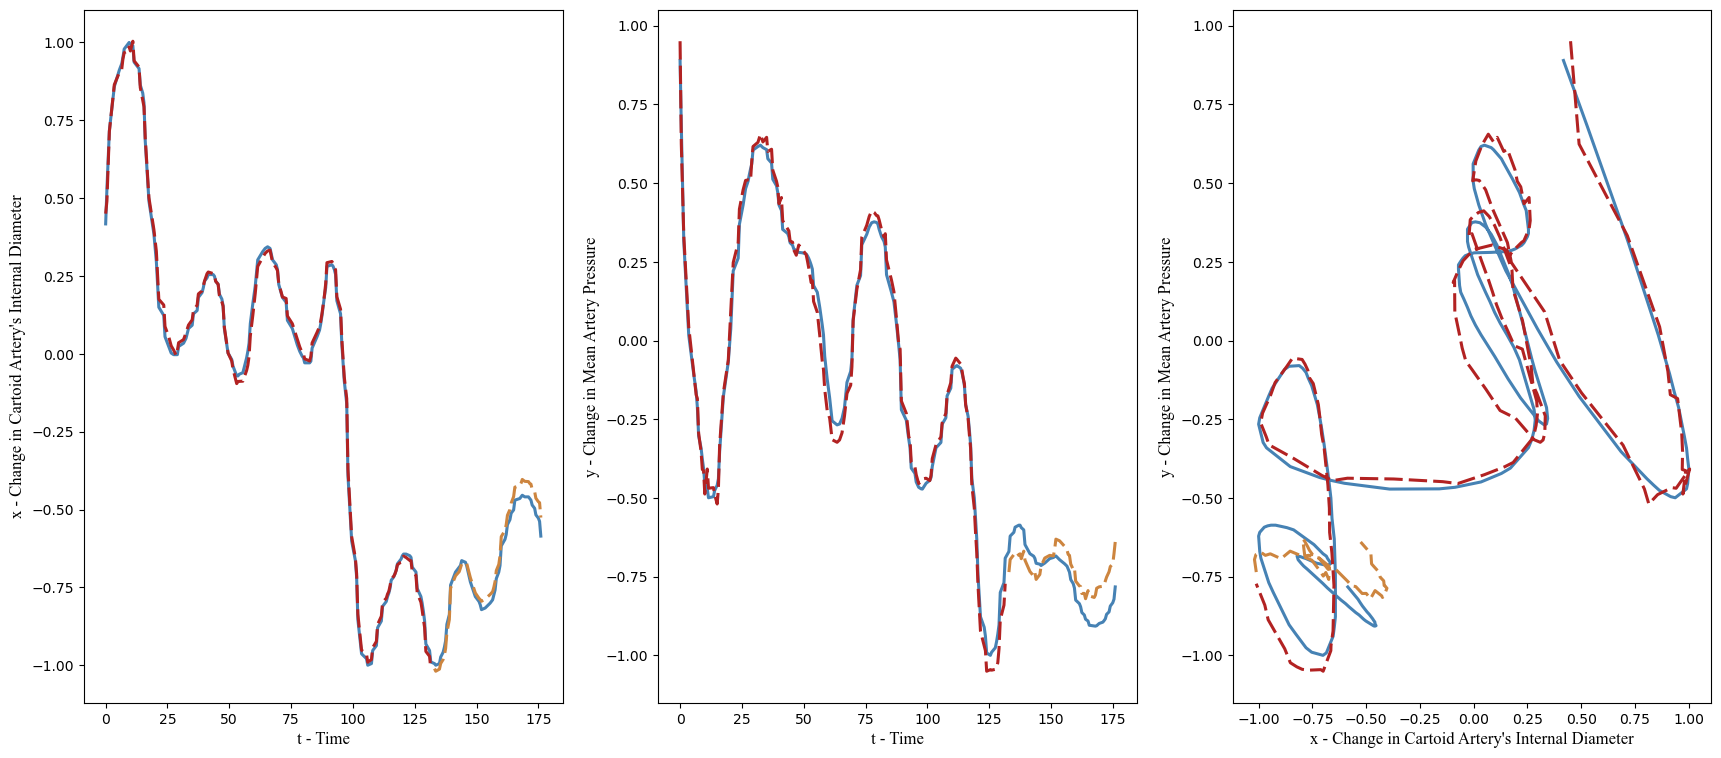

grad4q 0.00829822260014269
sIt: 7, Loss: 3.3864444122e-03, Time: 138.08
0.05
0.3205217395822532


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [01:27<00:00,  2.27it/s]


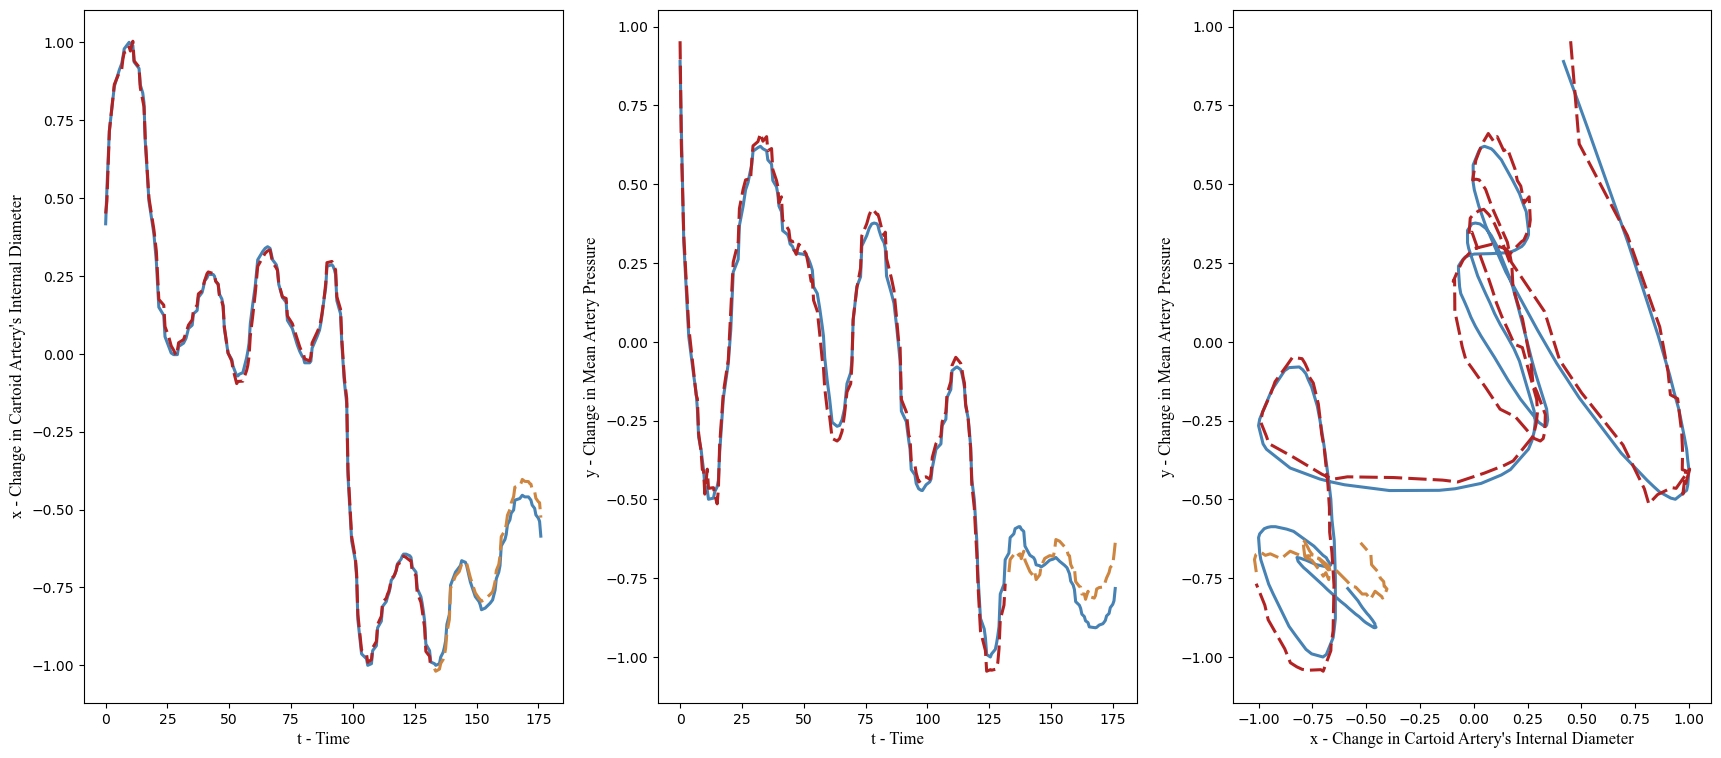

grad4q -0.05278586820389305
sIt: 8, Loss: 3.3971604425e-03, Time: 137.50
0.05
0.32104959826429214


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [01:27<00:00,  2.27it/s]


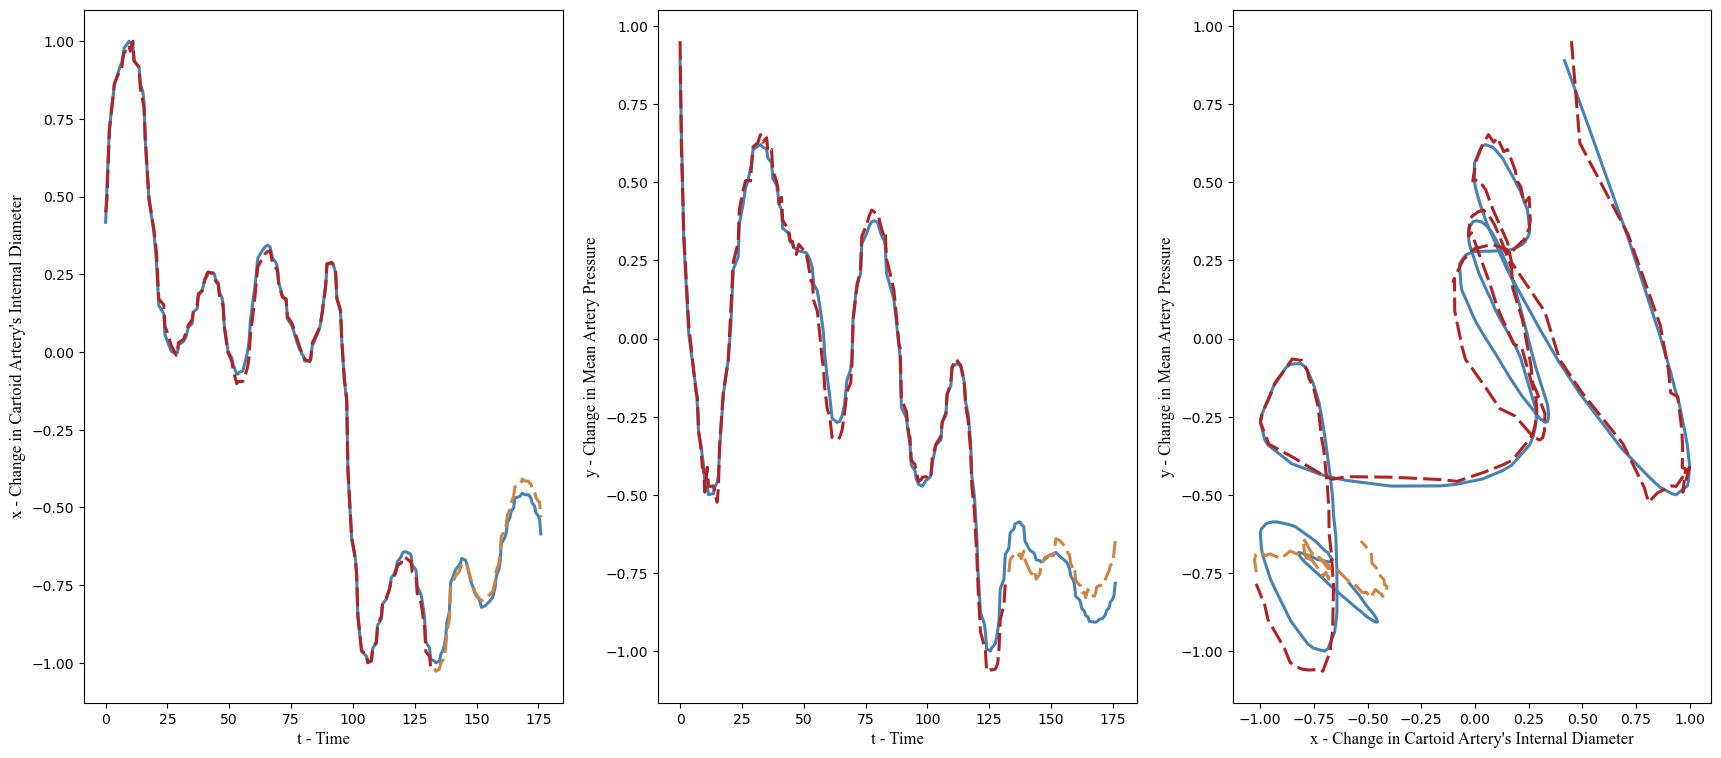

grad4q 0.08390570537490756
sIt: 9, Loss: 3.4455470741e-03, Time: 137.70
0.05
0.32021054121054304


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [01:29<00:00,  2.22it/s]


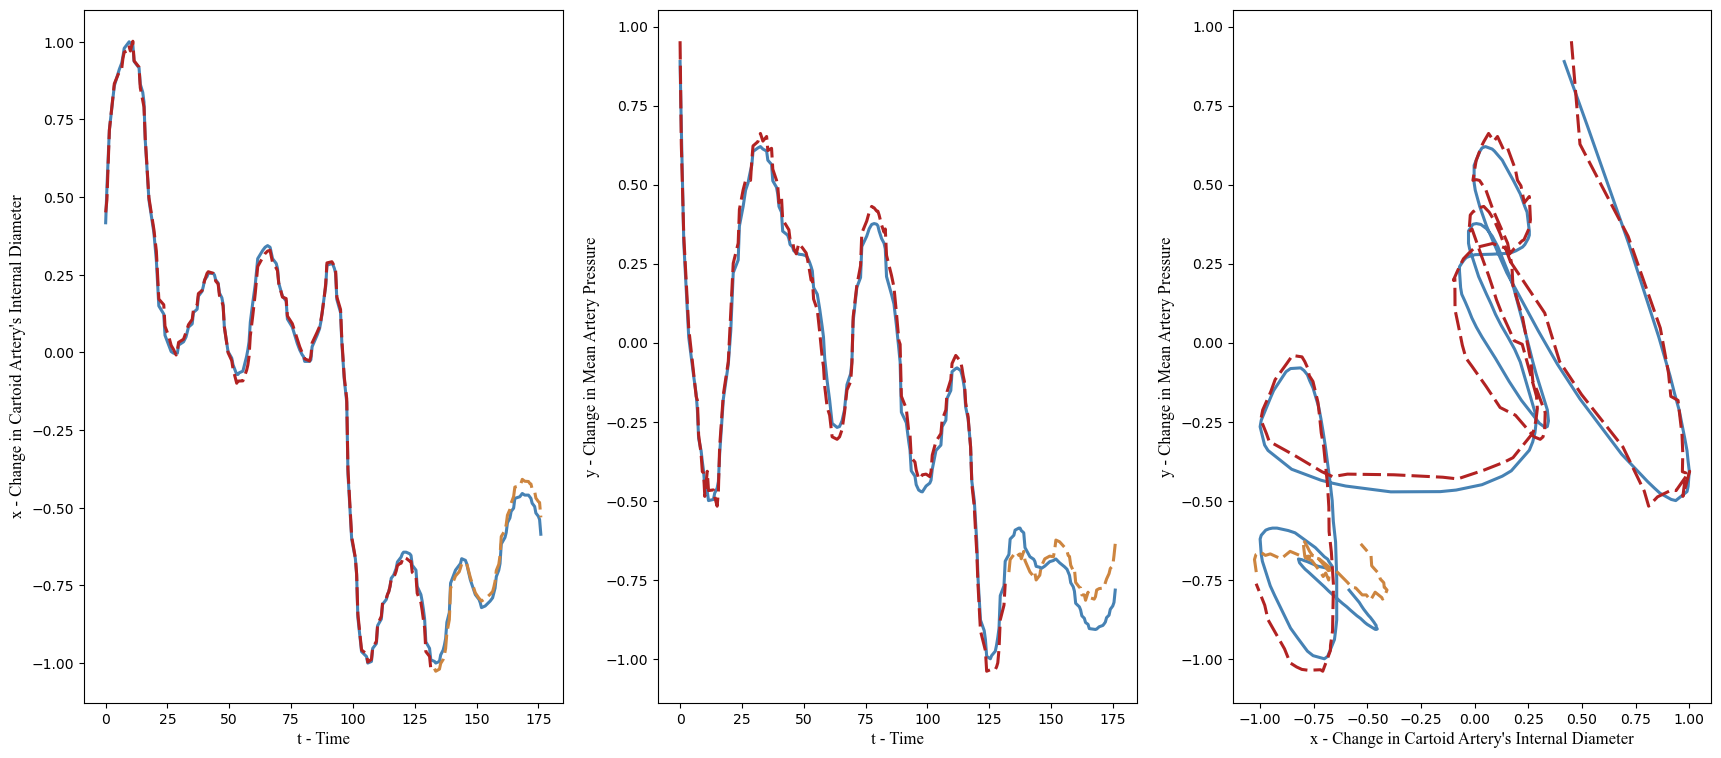

grad4q -0.08852546556748639
sIt: 10, Loss: 3.4537869506e-03, Time: 138.44
0.05
0.3210957958662179


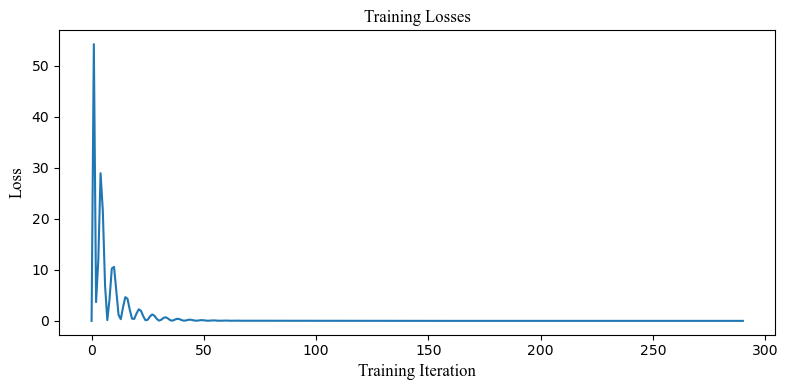

100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [01:28<00:00,  2.25it/s]


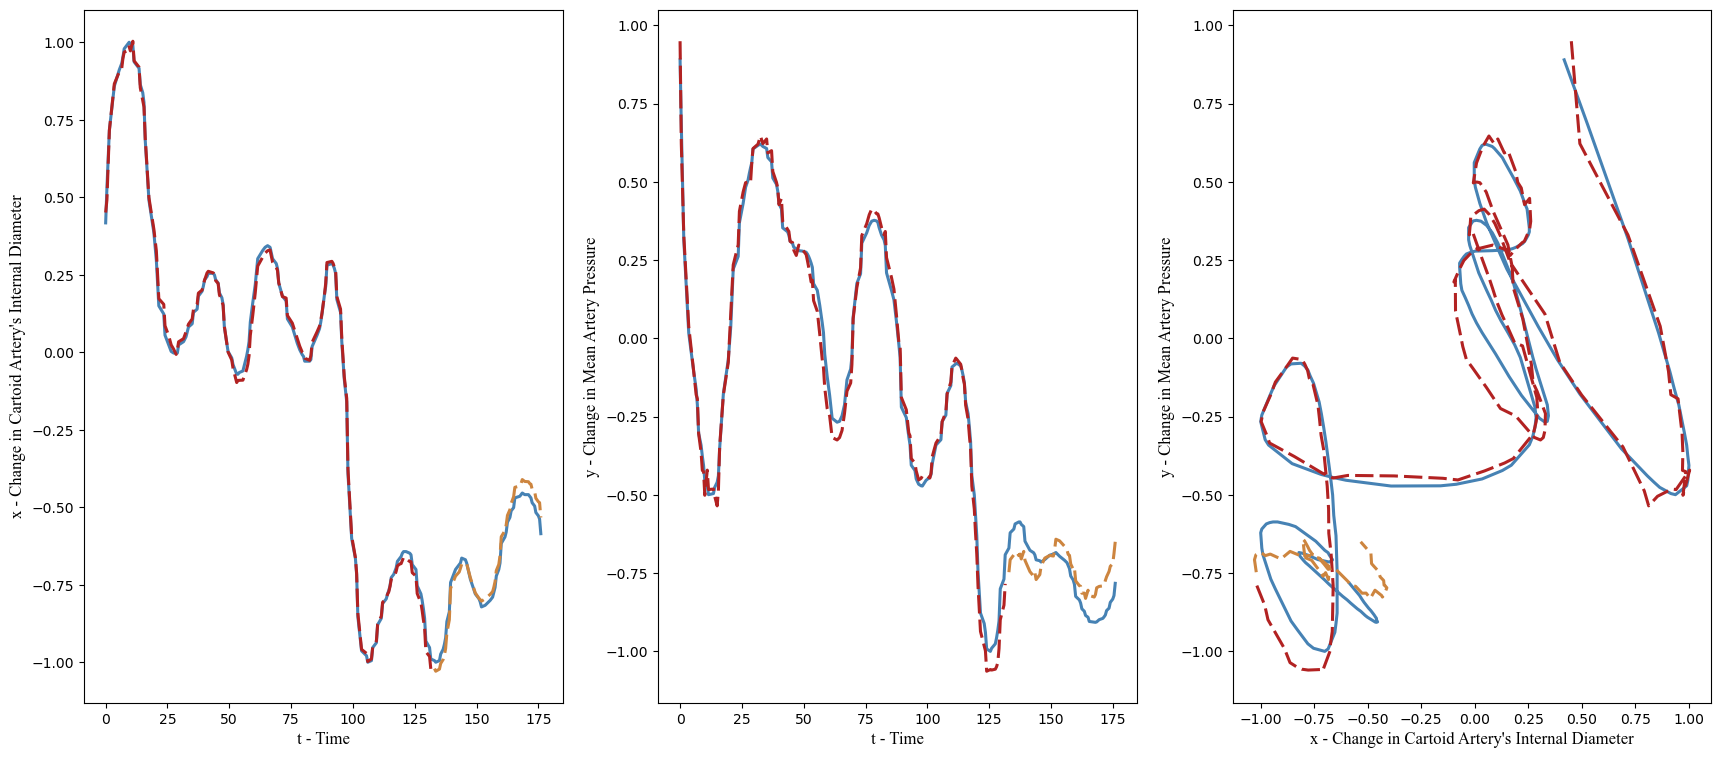

grad4q 0.09301211023559759
sIt: 11, Loss: 3.4023788758e-03, Time: 139.45
0.05
0.32016567476386193


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [01:26<00:00,  2.31it/s]


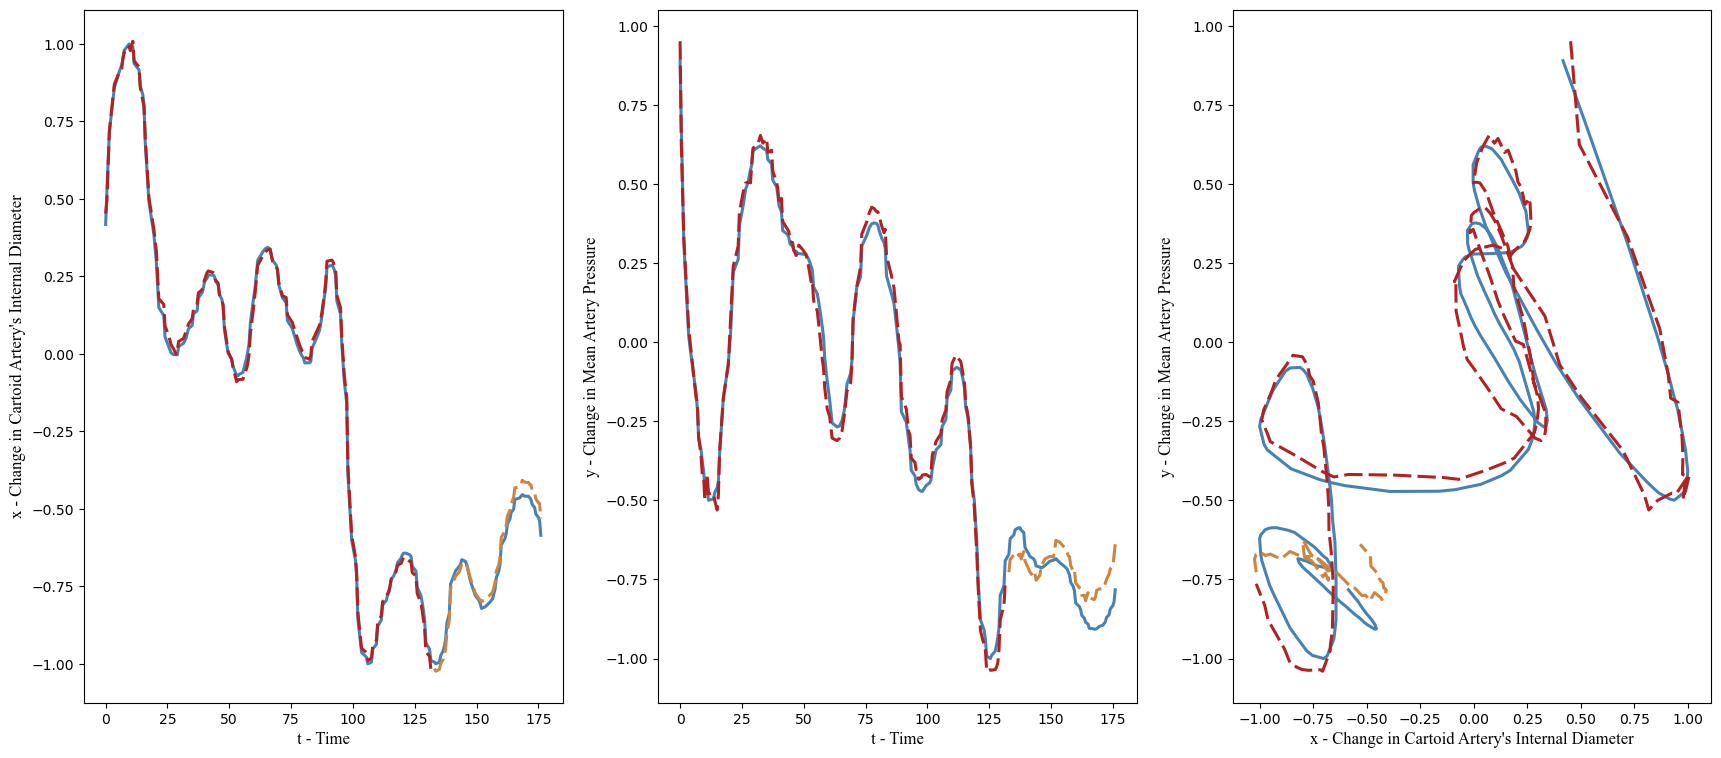

grad4q -0.0656366430513756
sIt: 12, Loss: 3.3730166033e-03, Time: 135.45
0.05
0.3208220411943757


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [01:25<00:00,  2.32it/s]


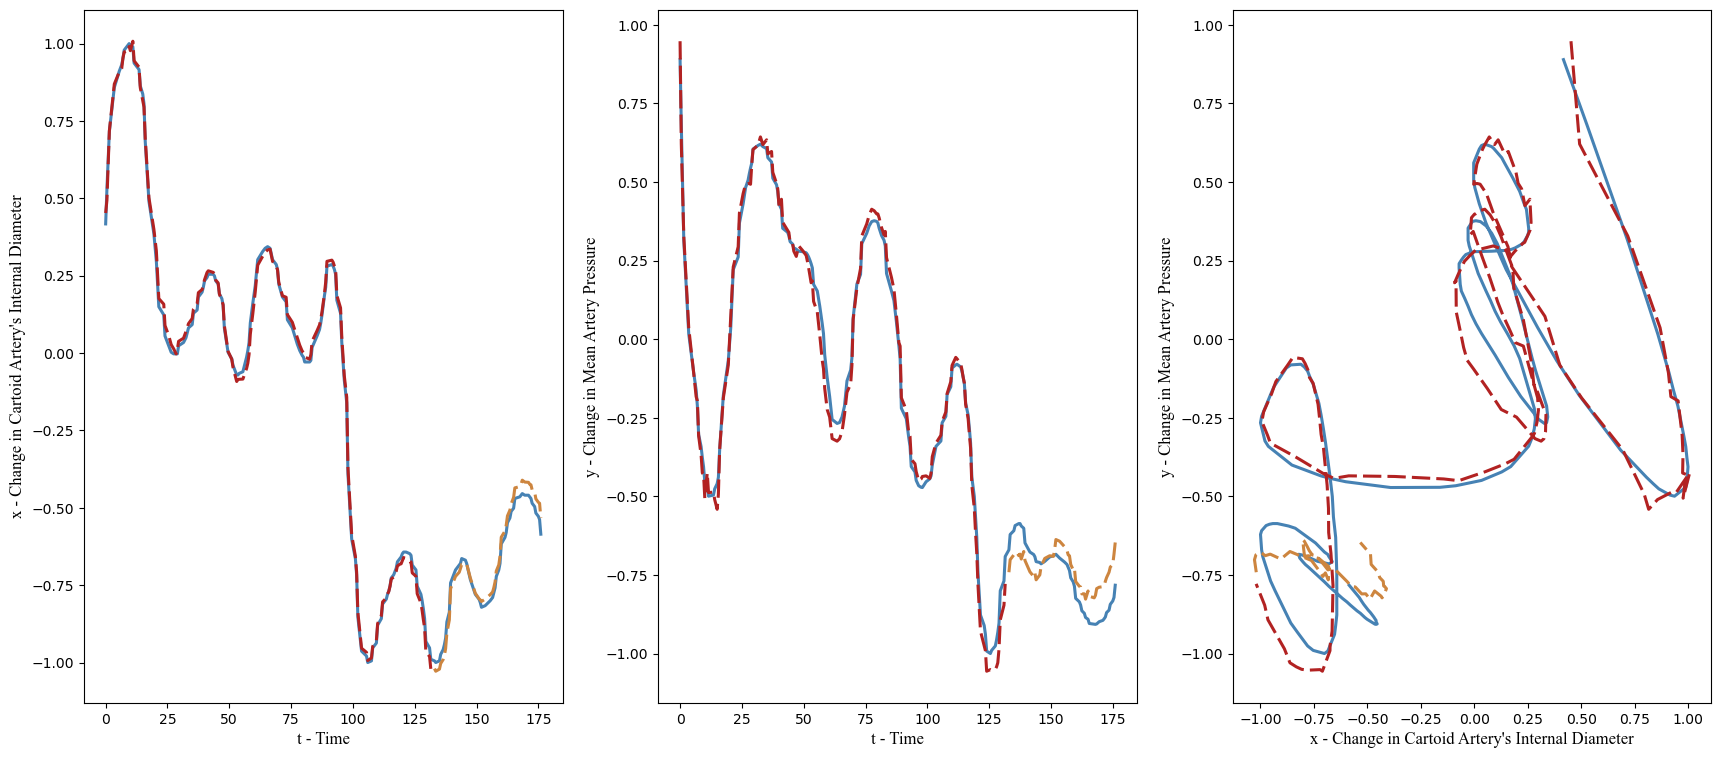

grad4q 0.06470262905737492
sIt: 13, Loss: 3.3596211579e-03, Time: 135.37
0.05
0.32017501490380196


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [01:29<00:00,  2.23it/s]


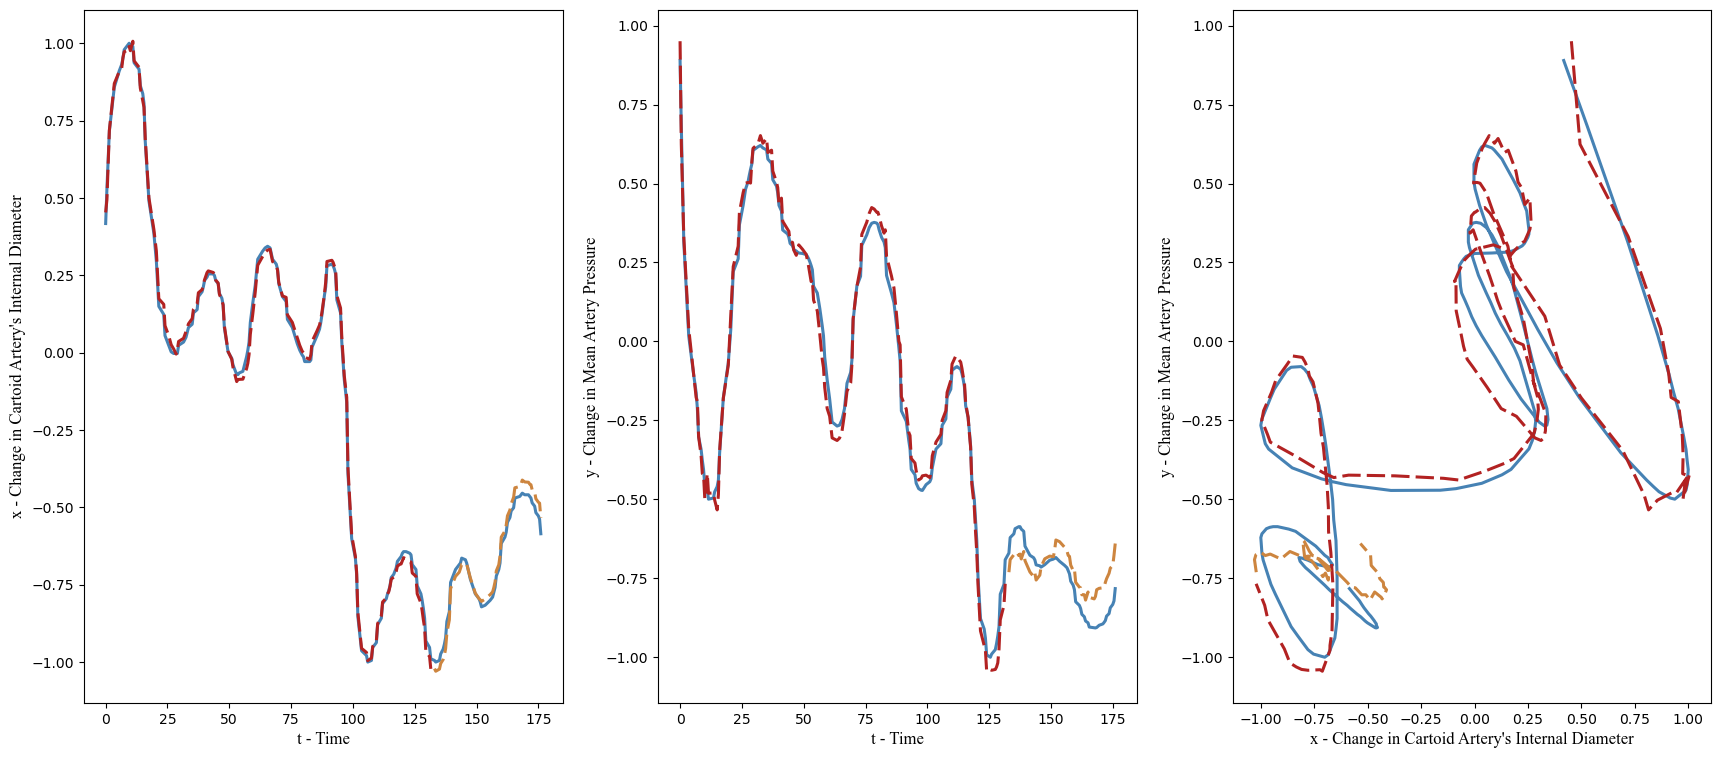

grad4q -0.024966995858717526
sIt: 14, Loss: 3.3302779775e-03, Time: 139.03
0.05
0.3204246848623891


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [01:28<00:00,  2.25it/s]


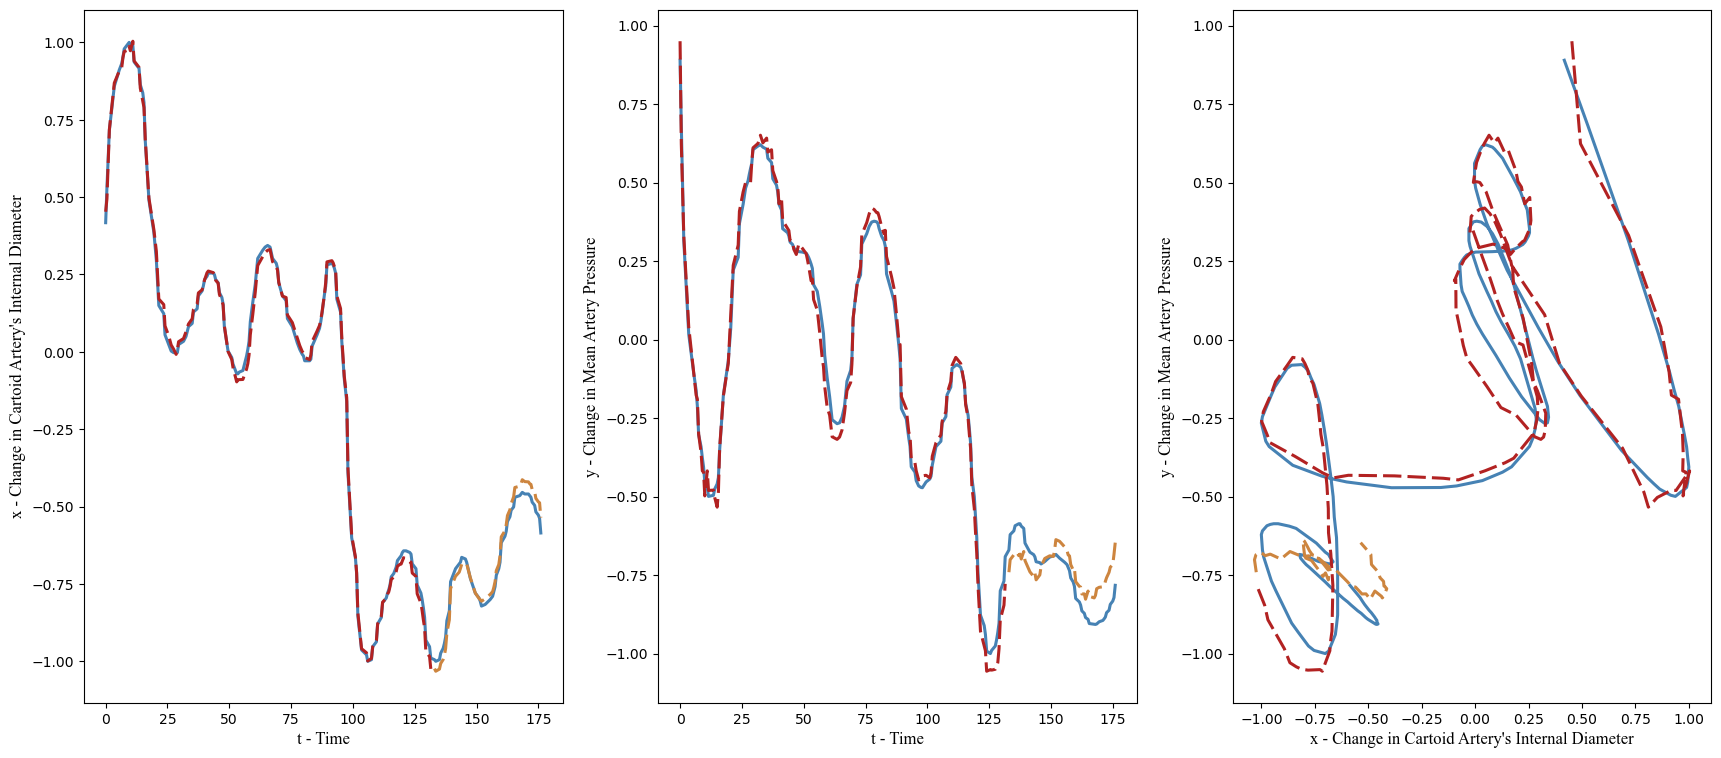

grad4q 0.04204993282261663
sIt: 15, Loss: 3.3129879739e-03, Time: 139.16
0.05
0.32000418553416293


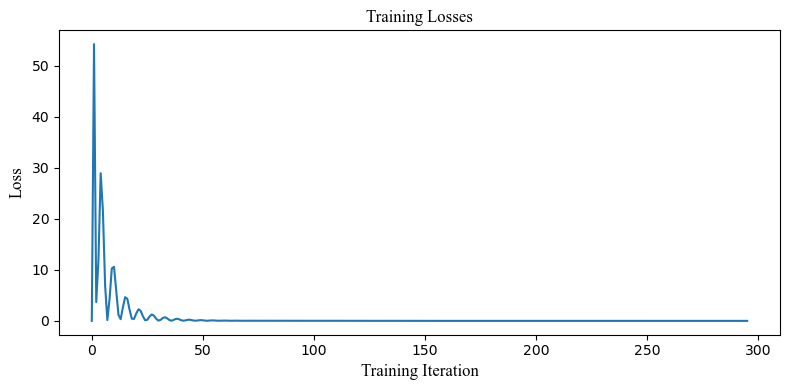

100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [01:27<00:00,  2.28it/s]


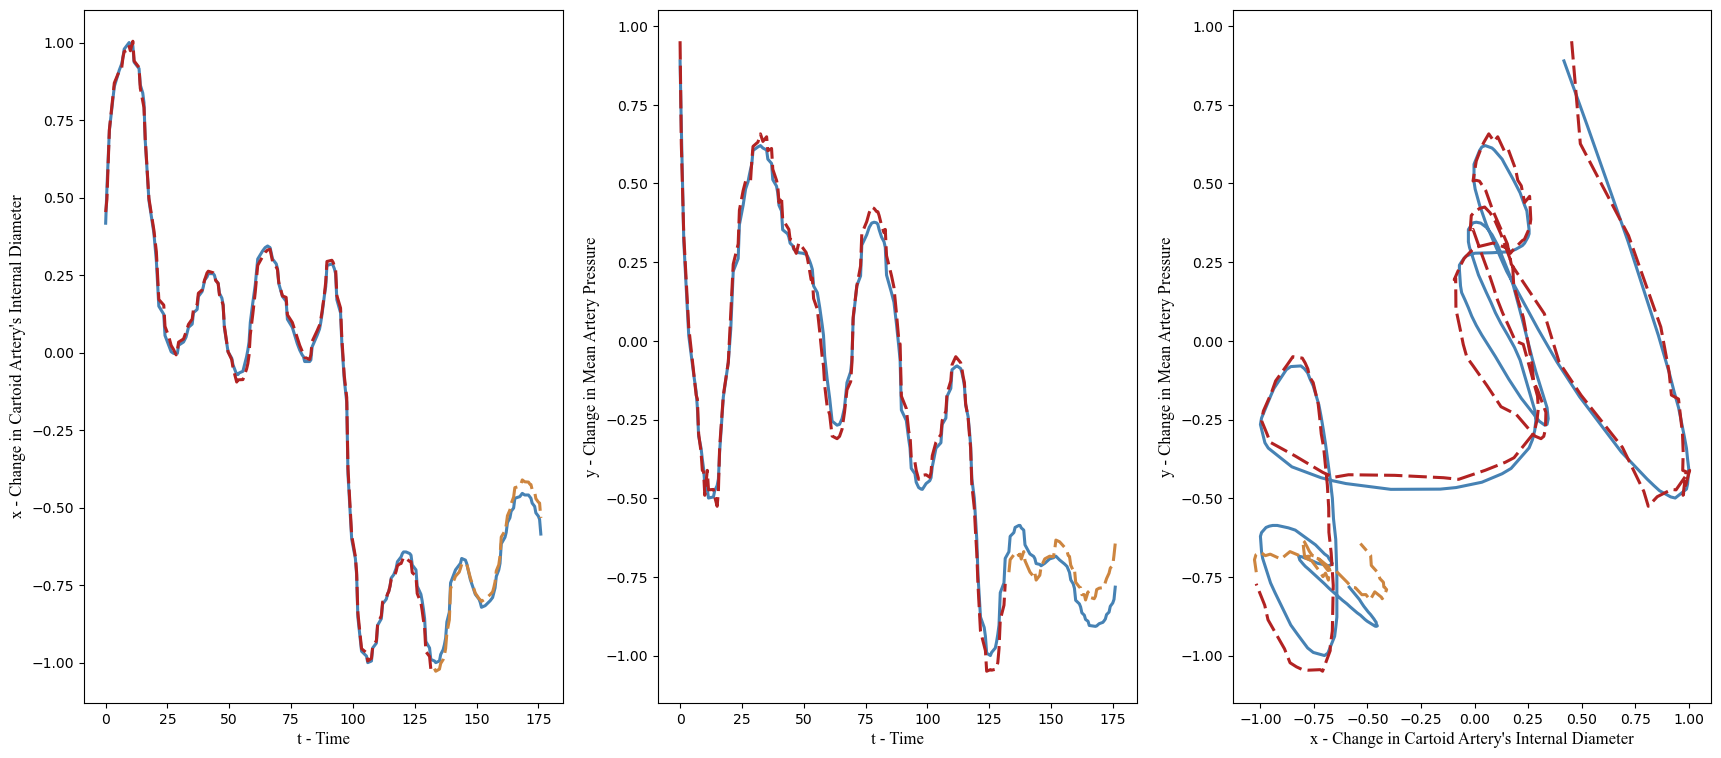

grad4q -0.02794601509131021
sIt: 16, Loss: 3.2829004340e-03, Time: 137.21
0.05
0.32028364568507606


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [01:27<00:00,  2.28it/s]


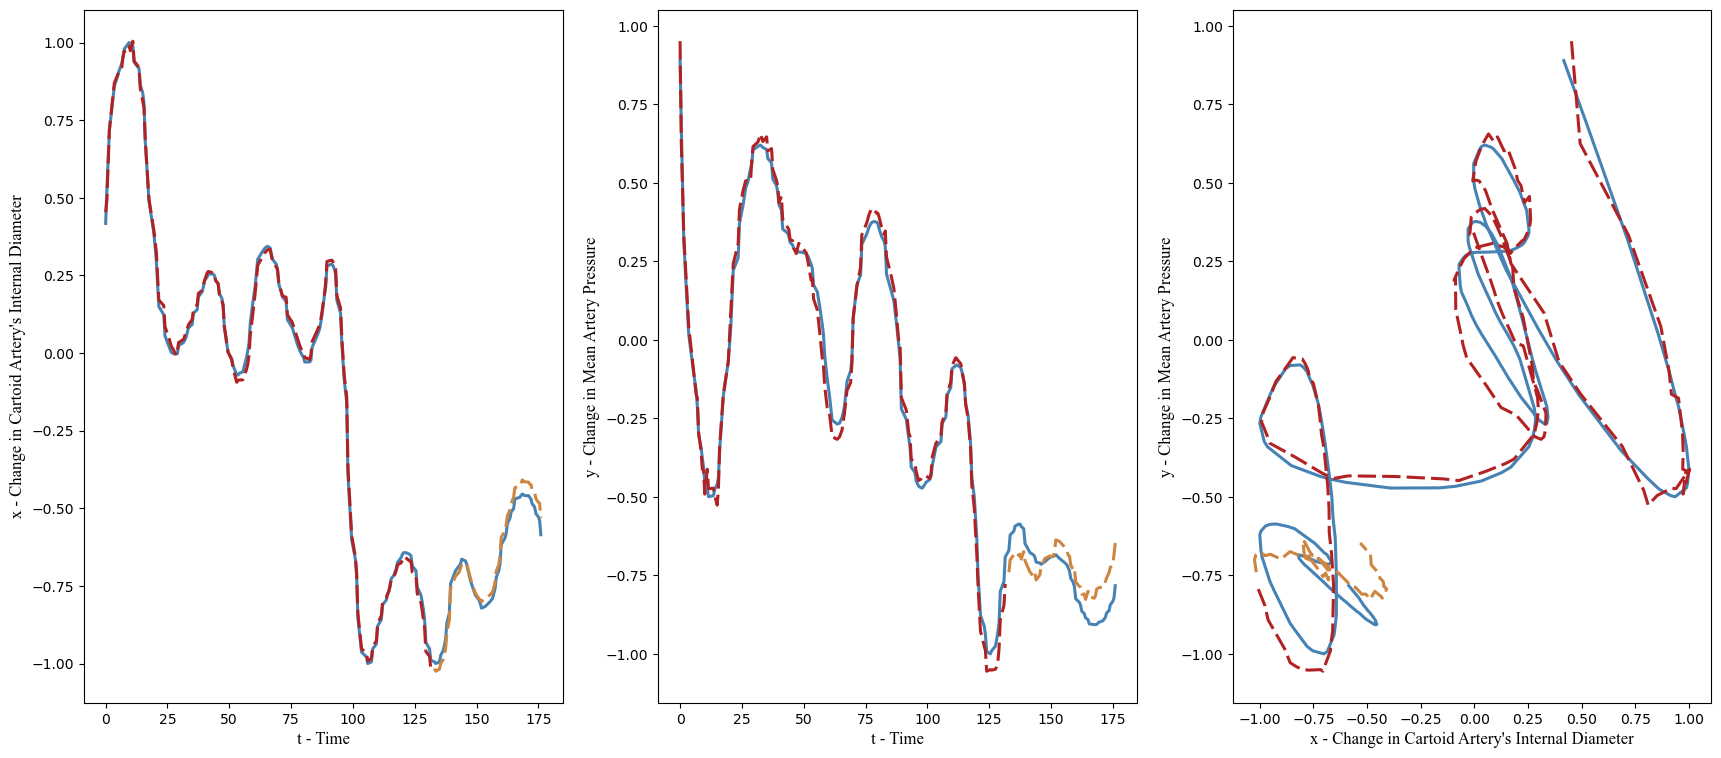

grad4q 0.009898946359136674
sIt: 17, Loss: 3.2645477913e-03, Time: 136.46
0.05
0.3192937510491624


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [01:26<00:00,  2.30it/s]


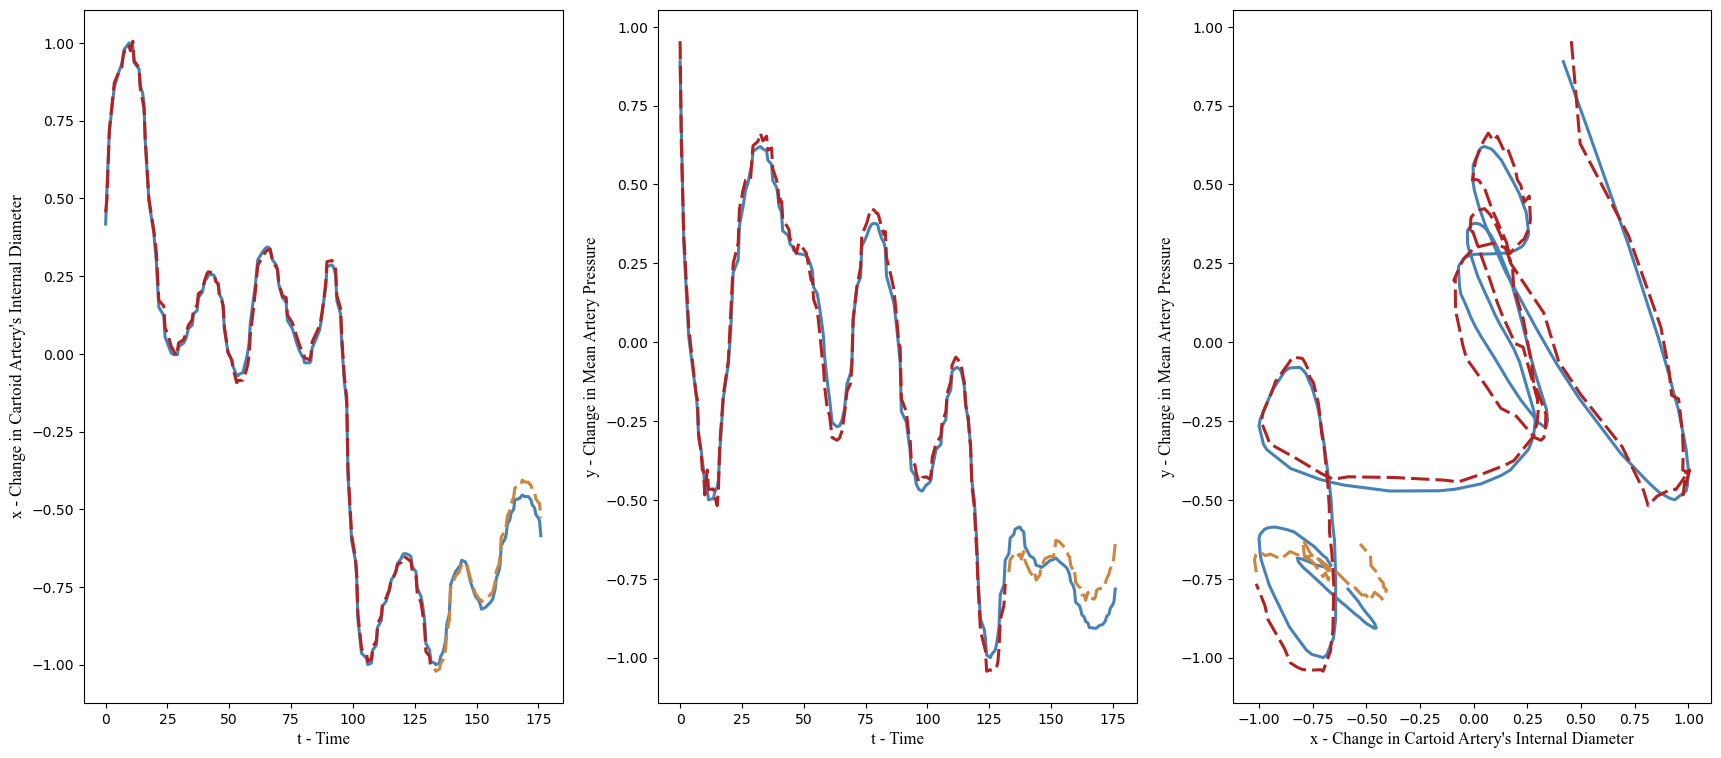

grad4q -0.06983439623670275
sIt: 18, Loss: 3.2975289505e-03, Time: 135.97
0.05
0.3199920950115294


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [01:26<00:00,  2.29it/s]


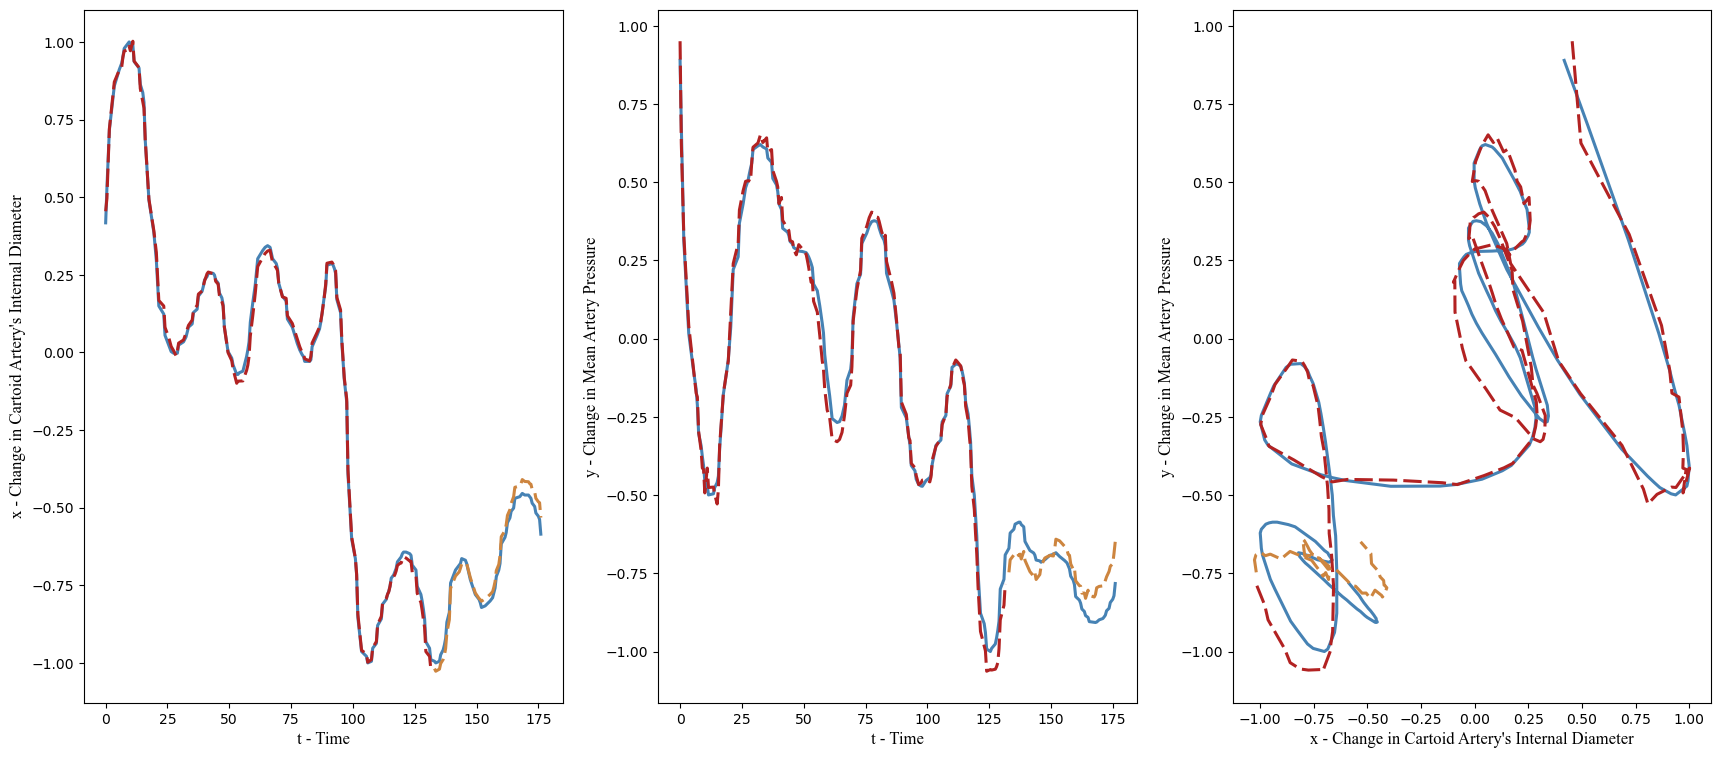

grad4q 0.1075081256834005
sIt: 19, Loss: 3.3747104462e-03, Time: 136.85
0.05
0.31988458688584603


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [01:26<00:00,  2.30it/s]


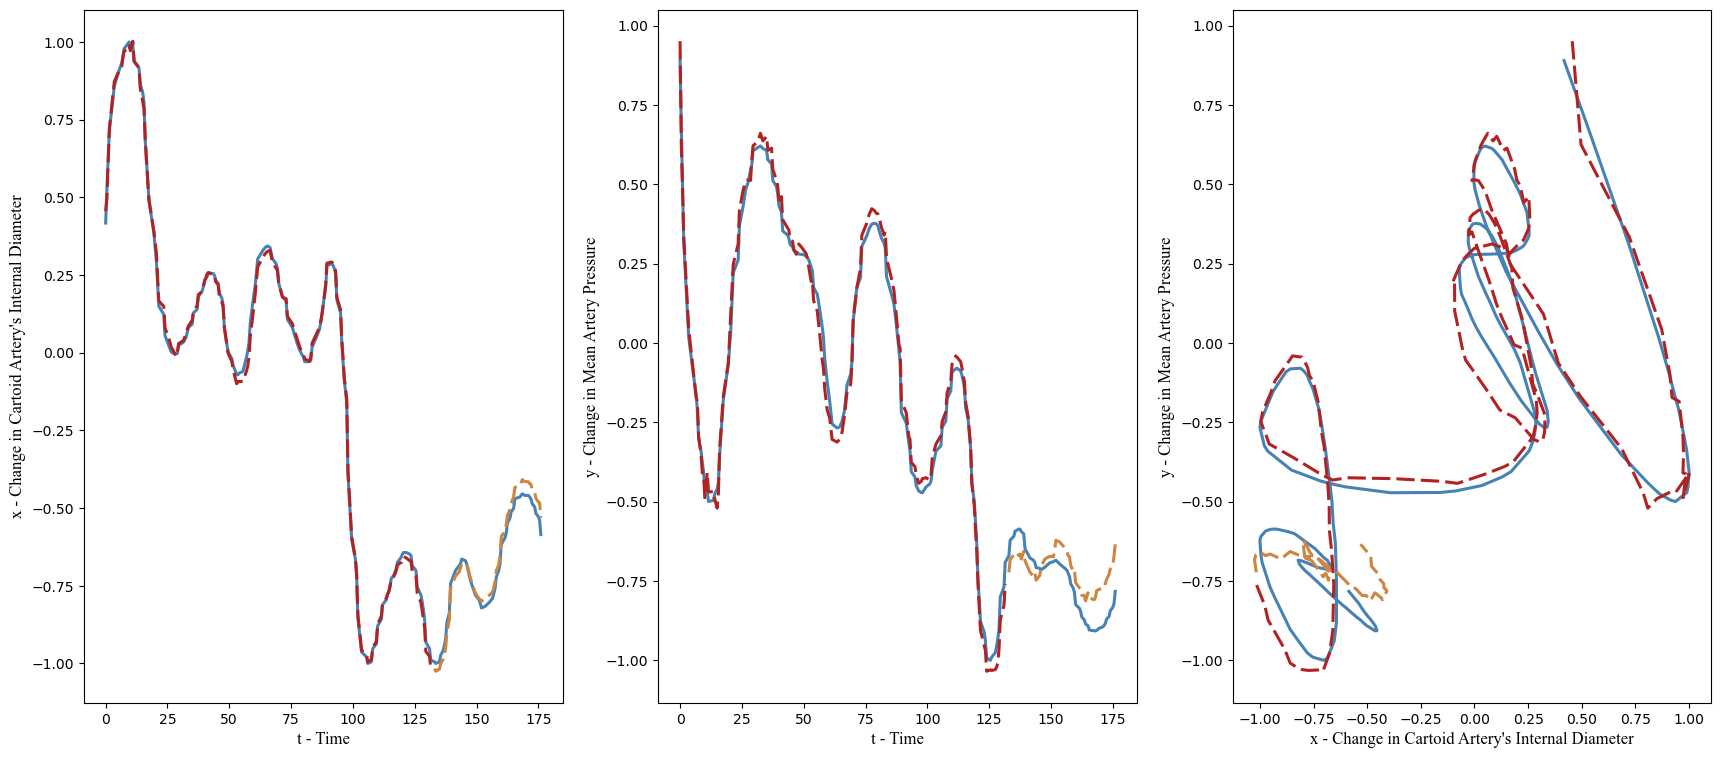

grad4q -0.06853910977314846
sIt: 20, Loss: 3.3392990008e-03, Time: 142.90
0.05
0.3205699779835775


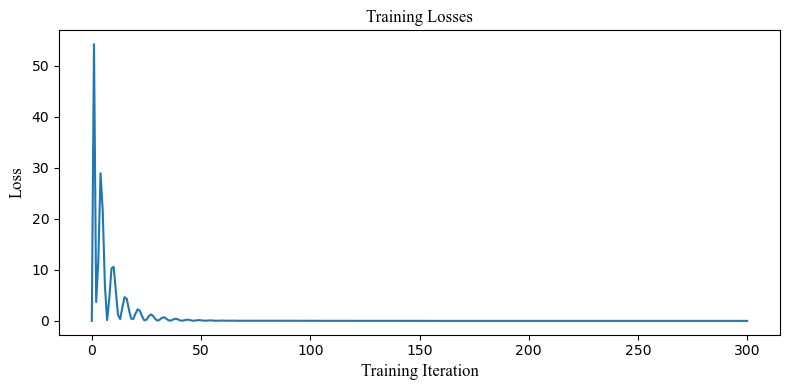

100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [01:33<00:00,  2.12it/s]


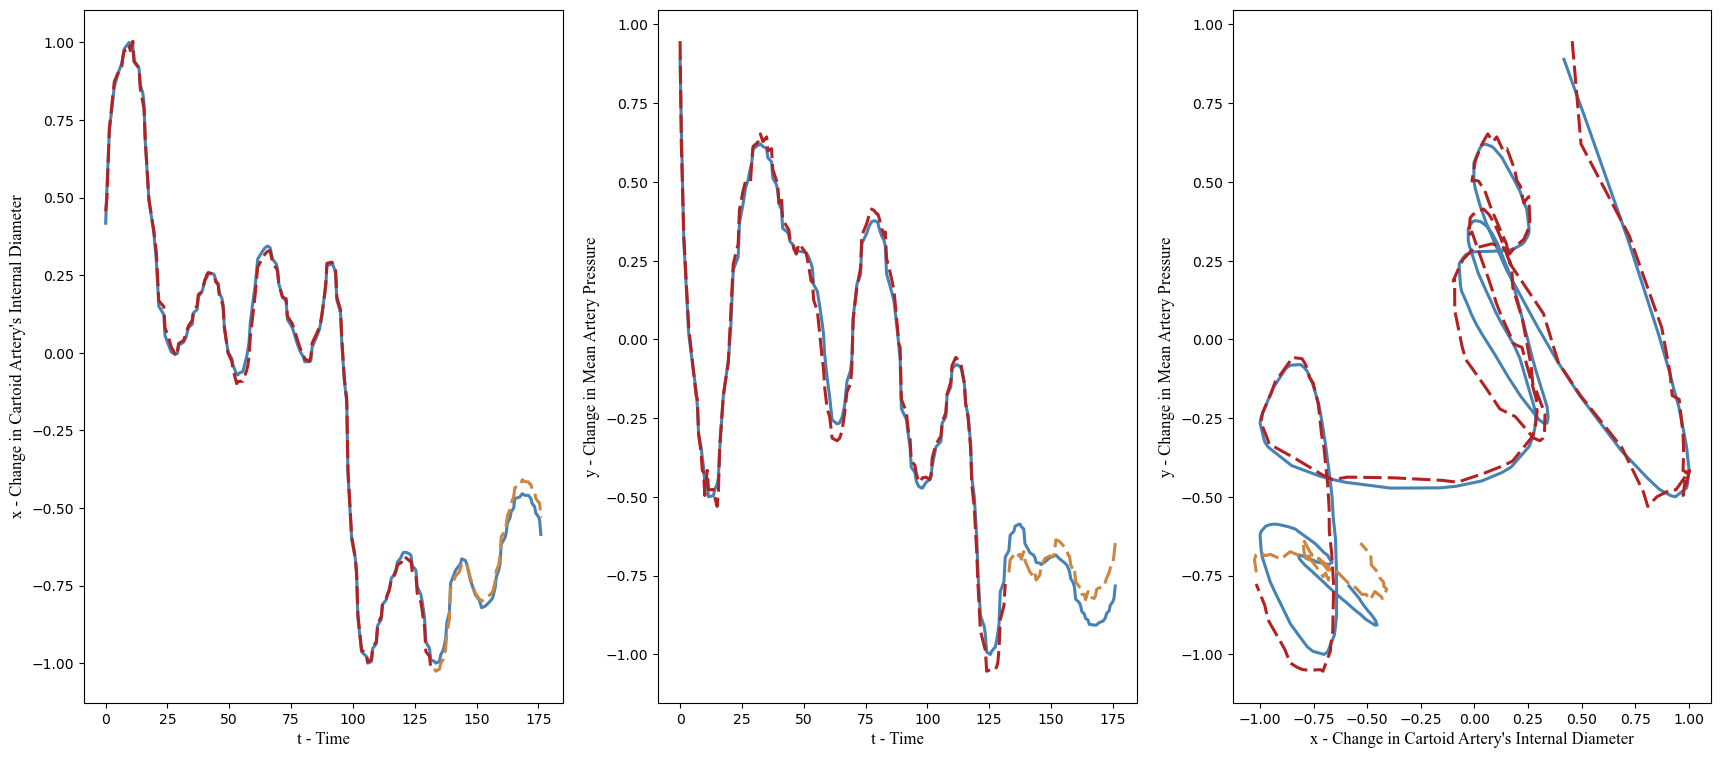

grad4q 0.044722804483419504
sIt: 21, Loss: 3.2444107346e-03, Time: 143.77
0.05
0.3201227499387433


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [01:26<00:00,  2.29it/s]


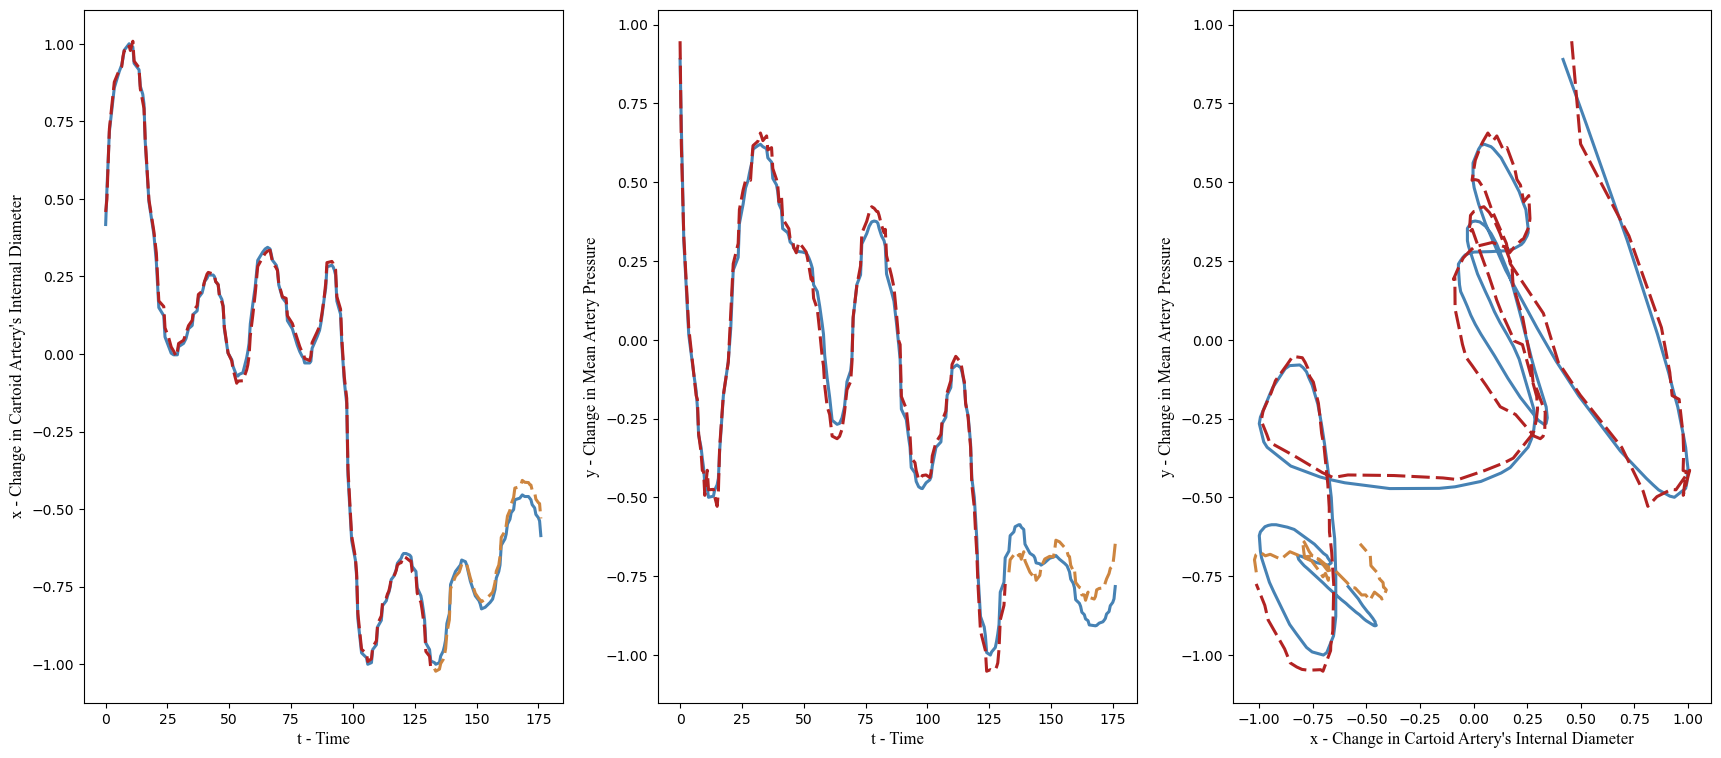

grad4q -0.013276005429201454
sIt: 22, Loss: 3.2260352746e-03, Time: 137.31
0.05
0.3202555099930353


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [01:27<00:00,  2.27it/s]


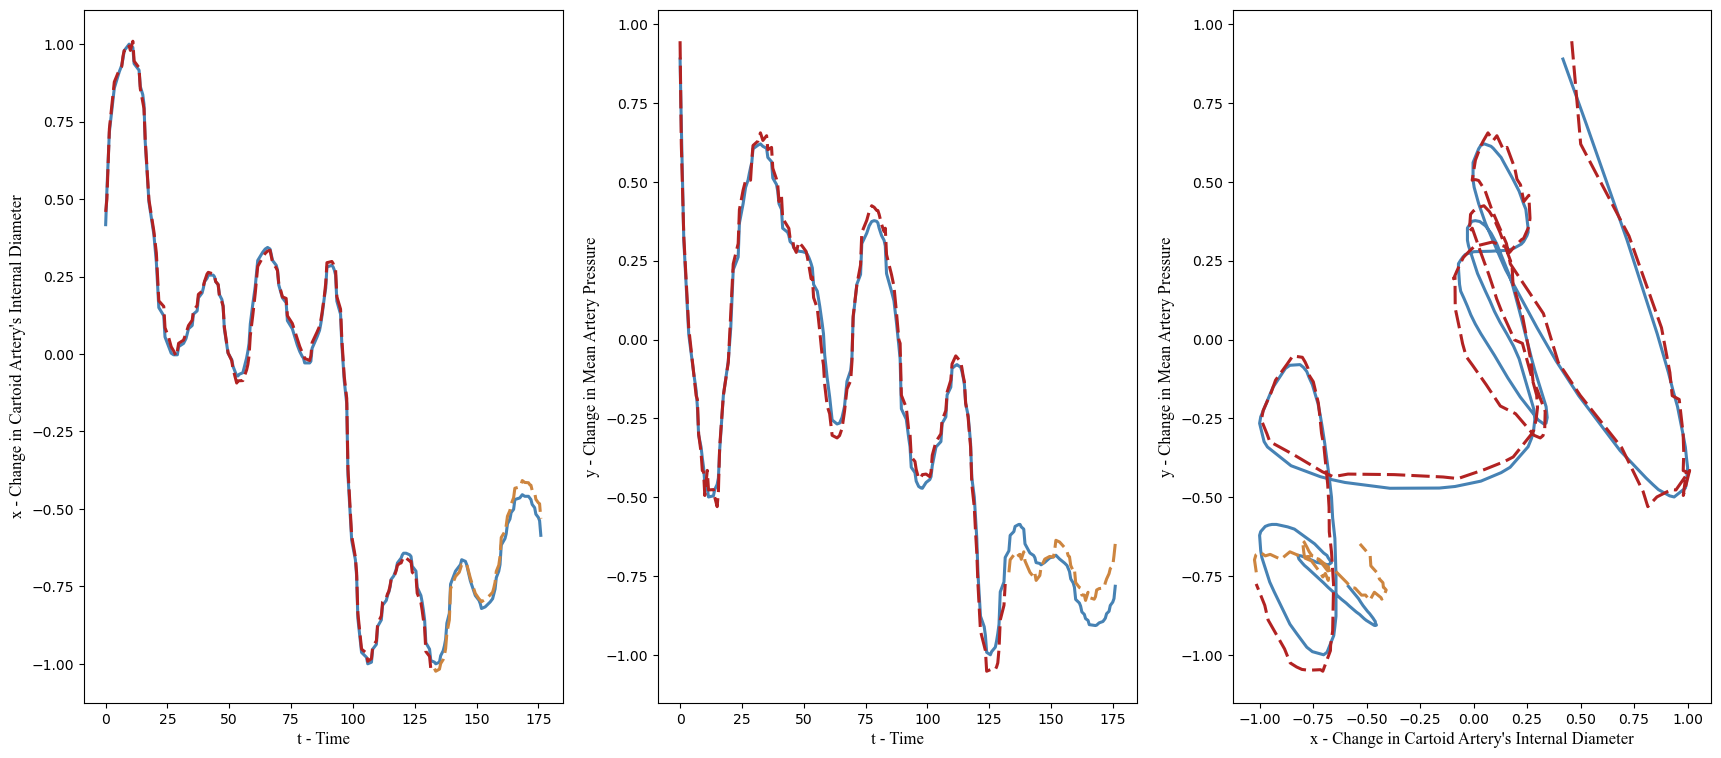

grad4q -0.012368941425056273
sIt: 23, Loss: 3.2226368785e-03, Time: 137.06
0.05
0.3203791994072859


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [01:25<00:00,  2.32it/s]


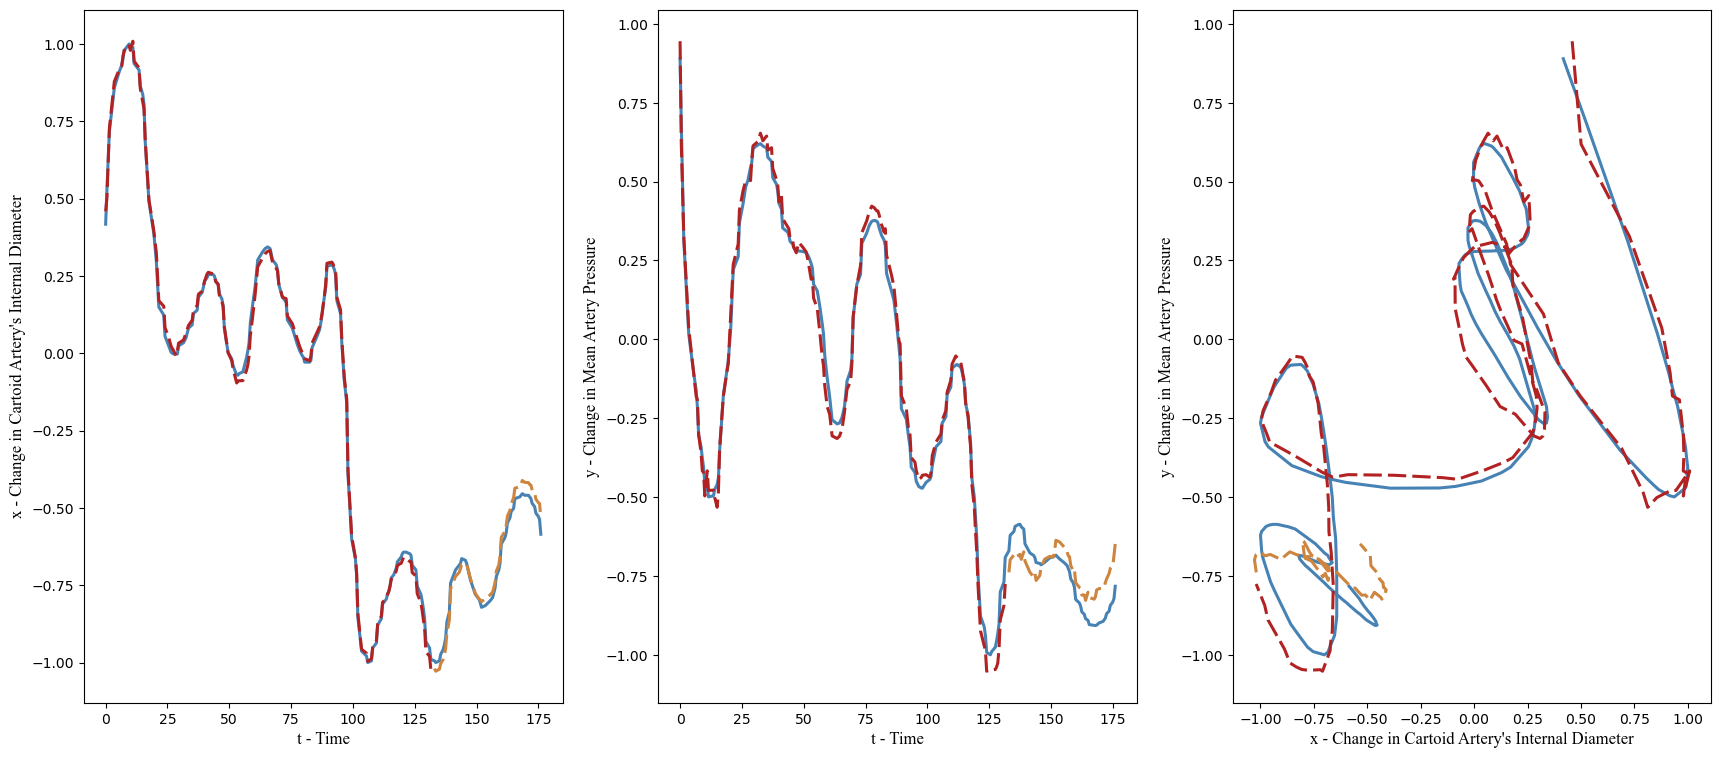

grad4q 0.010825060399069083
sIt: 24, Loss: 3.2085711136e-03, Time: 134.60
0.05
0.3202709488032952


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [01:25<00:00,  2.32it/s]


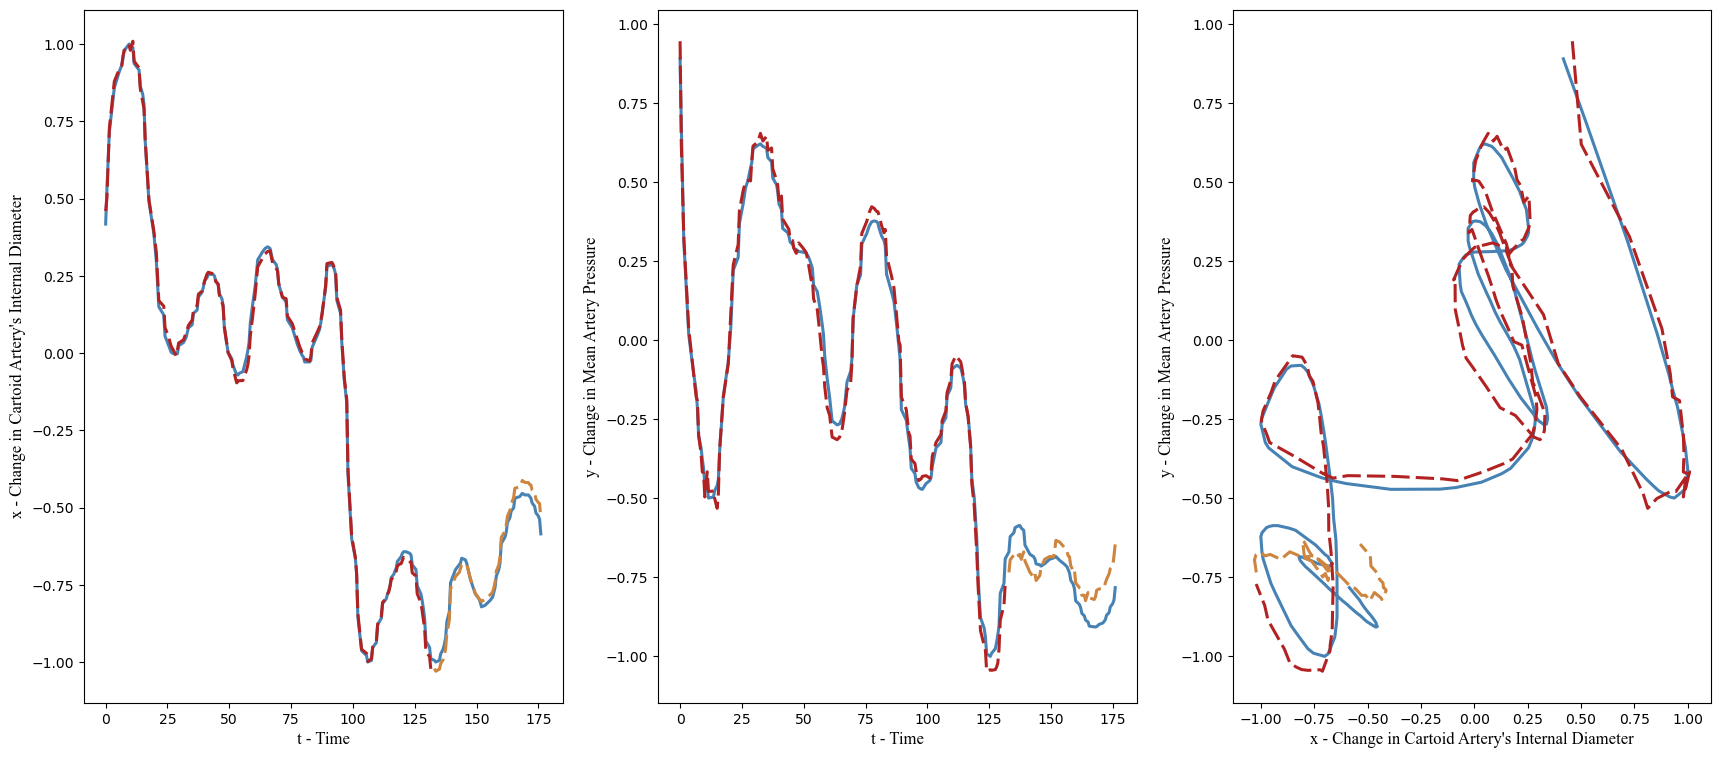

grad4q -0.0002482347217396375
sIt: 25, Loss: 3.2080169767e-03, Time: 134.98
0.05
0.32051918352503483


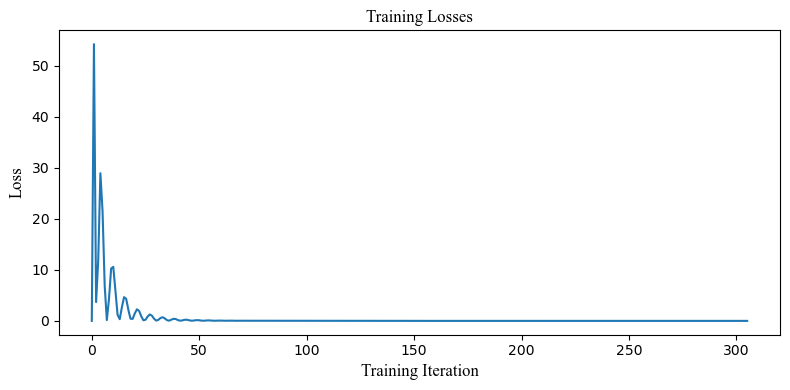

100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [01:26<00:00,  2.30it/s]


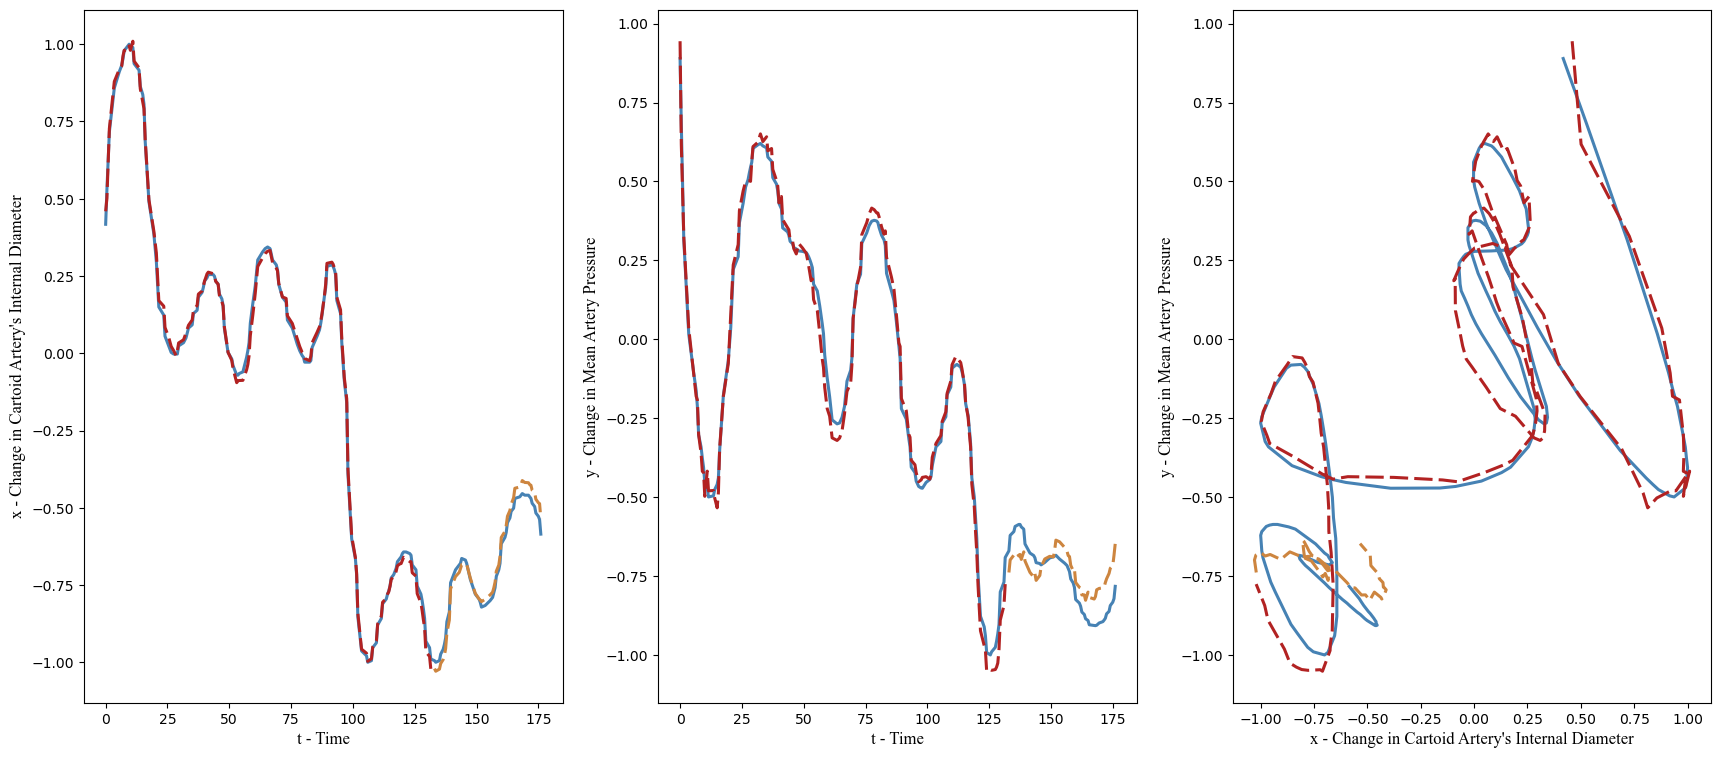

grad4q 0.03870840462930798
sIt: 26, Loss: 3.2037149649e-03, Time: 135.63
0.05
0.32013209947874177


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [01:26<00:00,  2.31it/s]


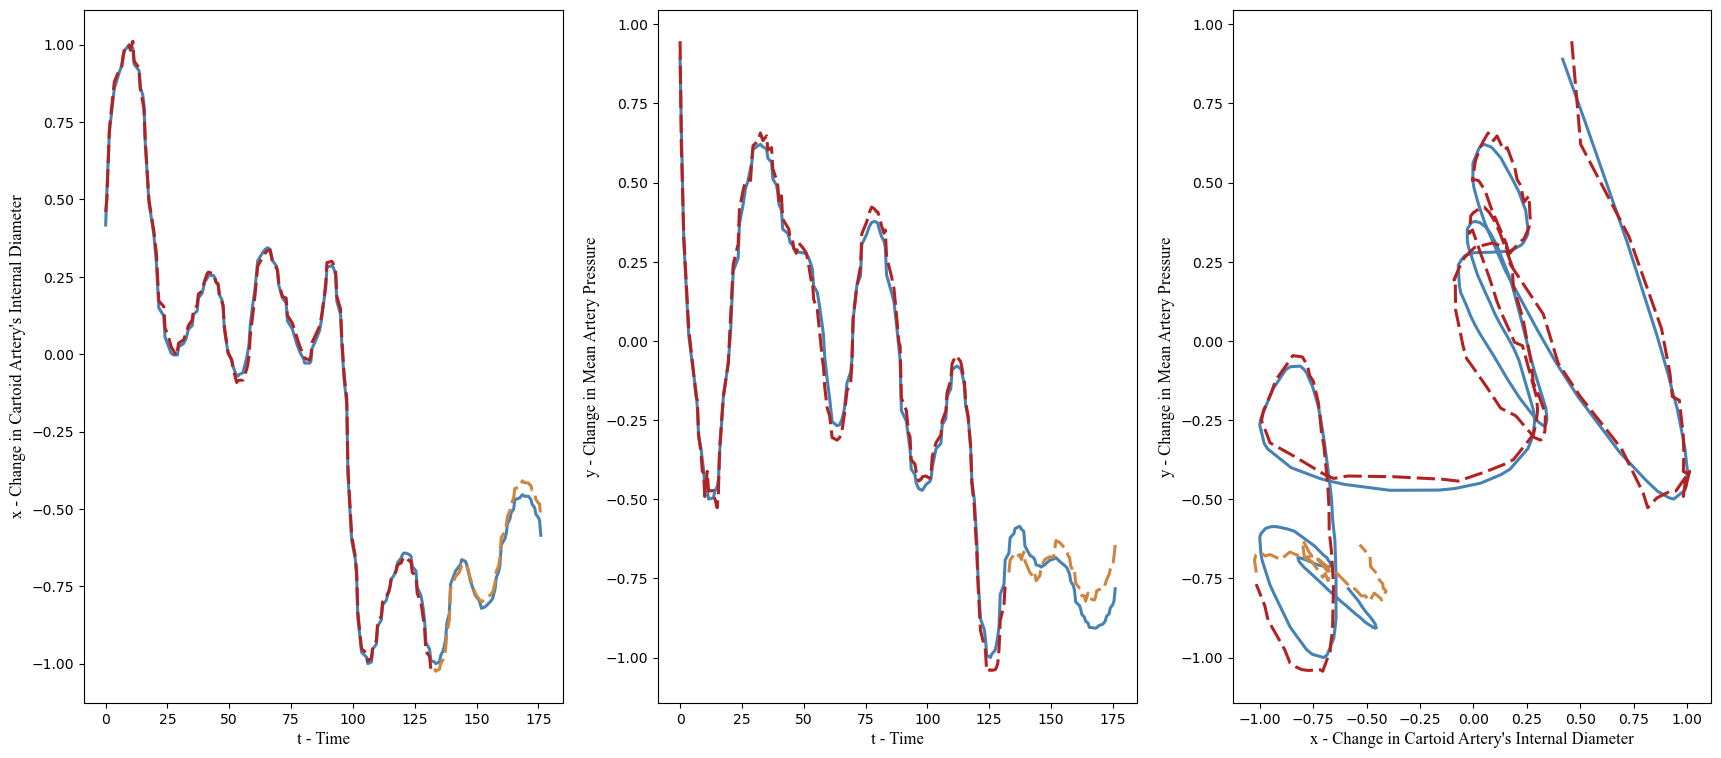

grad4q -0.03962533760449209
sIt: 27, Loss: 3.1984329689e-03, Time: 135.58
0.05
0.3205283528547867


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [01:26<00:00,  2.30it/s]


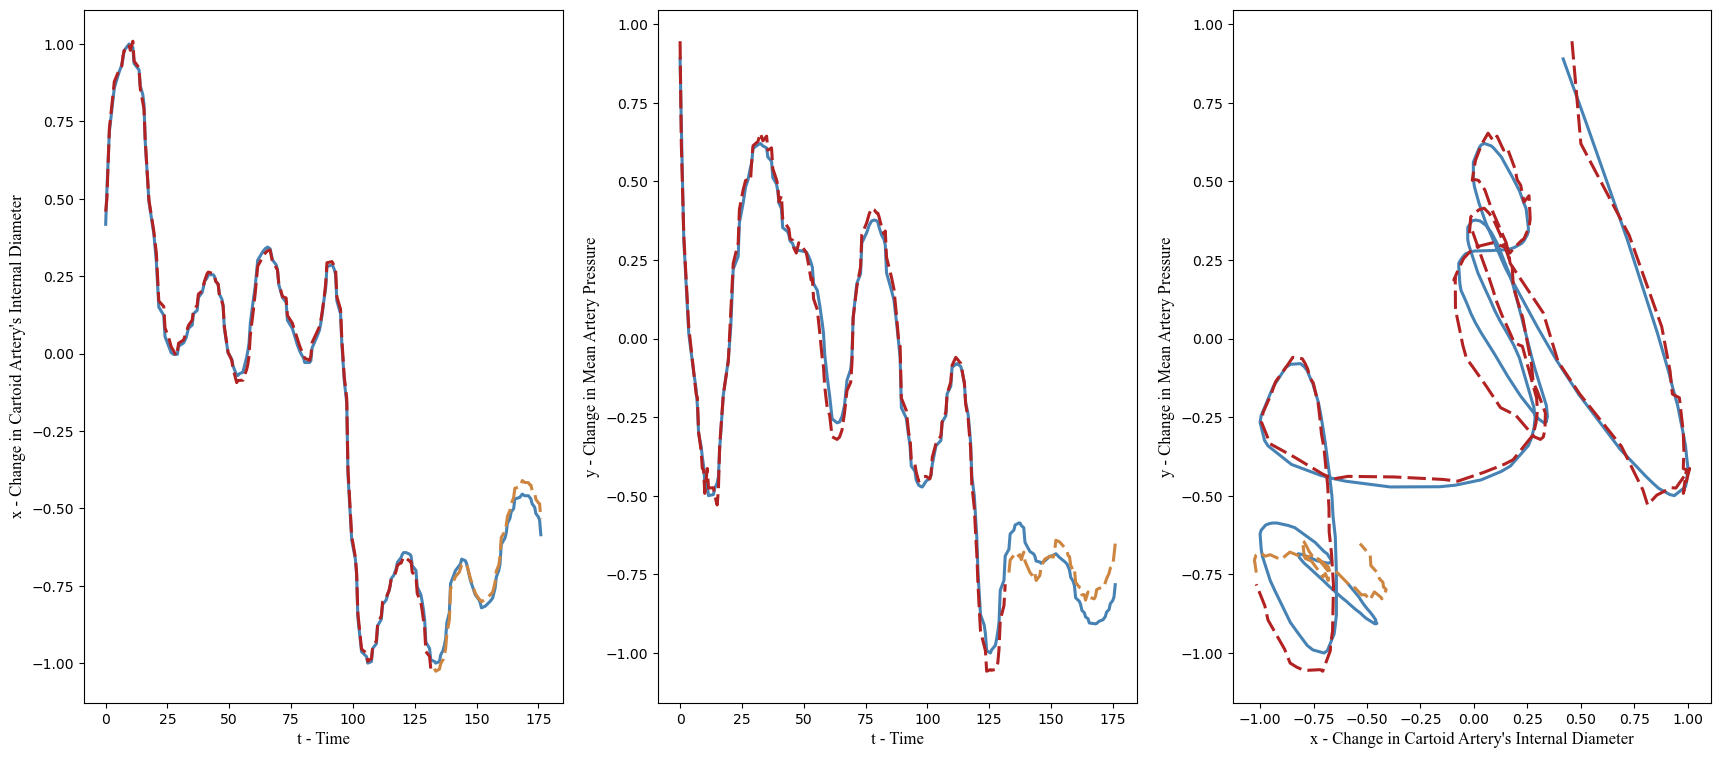

grad4q 0.048415721947977754
sIt: 28, Loss: 3.2007358968e-03, Time: 135.35
0.05
0.32004419563530695


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [01:26<00:00,  2.31it/s]


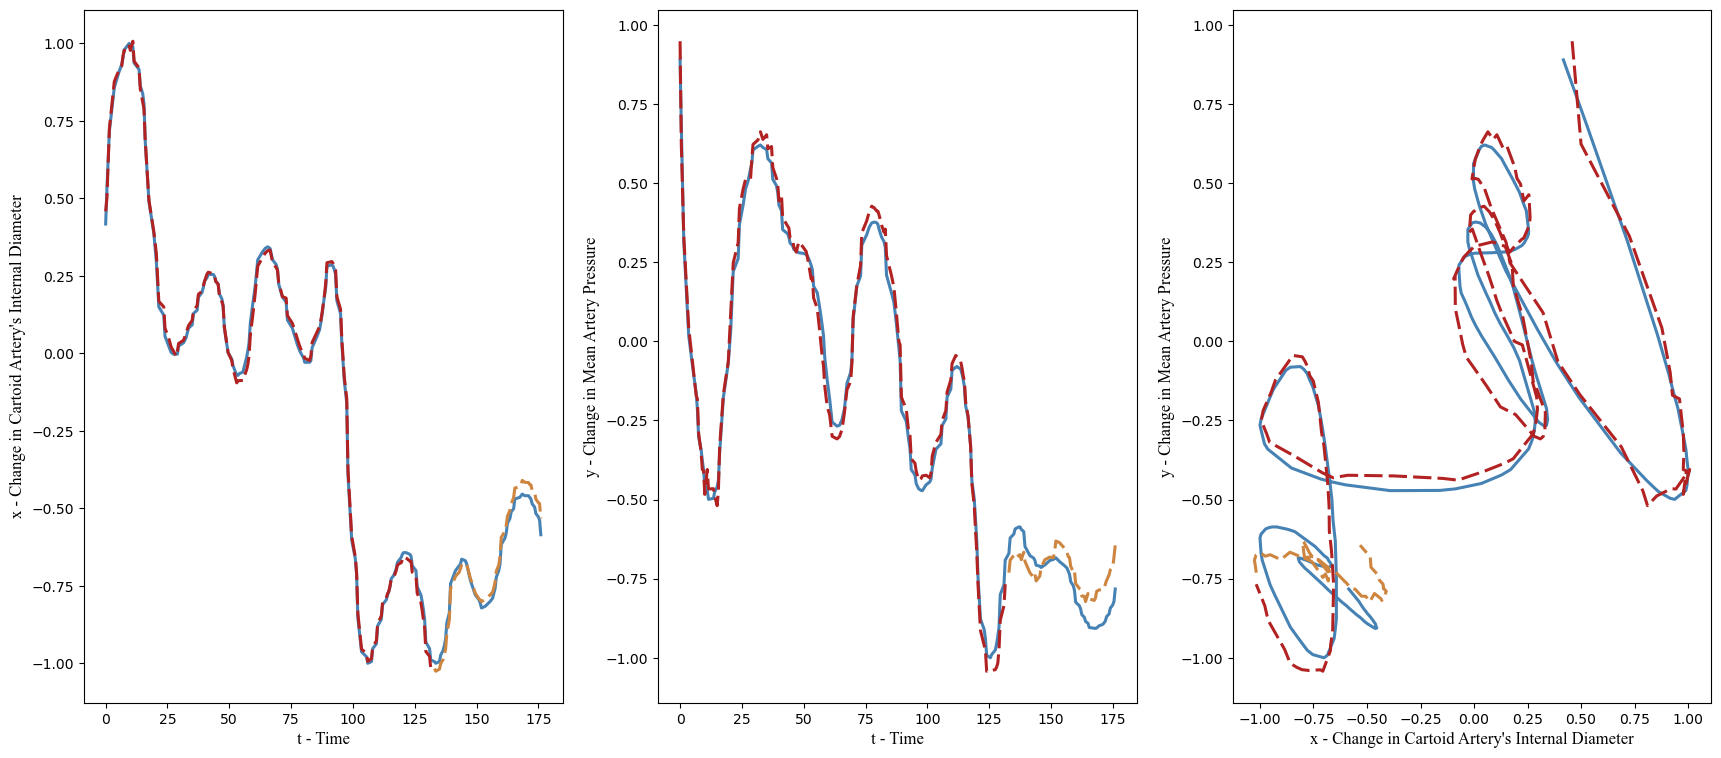

grad4q -0.06306208838151081
sIt: 29, Loss: 3.2074146438e-03, Time: 135.83
0.05
0.32067481651912205


In [16]:
for it in range(30):
    # Y_pred =   # S x N x D
    # appx = calappx(NN, q, 0.01, realData, NX)
    appx, grad4q = calappx(NN, q, realt, realData, N, NX, NVar)
    print("grad4q", grad4q)
    loss = torch.sum(torch.square(appx)) / NX
    optimizer_Adam.zero_grad()
    loss.backward(retain_graph=True)
    l = loss.item()
    if l < lossmin:
        lossmin = l
        torch.save(NN.state_dict(), r'C:\Users\Admin\Desktop\NN Discovery\code\Frac_NN_alpha_min_duffing.pkl')
        torch.save(q, r'C:\Users\Admin\Desktop\NN Discovery\code\q_value_min_duffing.pth')

    optimizer_Adam.step()
    learning_rate4q = np.power(10, -np.ceil(np.log10(abs(grad4q))) - 3)
    q = q - learning_rate4q * grad4q
    if q < 0:
        q = 0.0001
    if q > 1:
        q = 0.9999

    q_value.append(q)

    # scheduler.step()
    # logging.info(loss.item())
    if it % 1 == 0:
        losses.append(loss.item())
        elapsed = timeit.default_timer() - start_time
        print('sIt: %d, Loss: %.10e, Time: %.2f' %(it, loss.item(), elapsed))
        print(optimizer_Adam.state_dict()['param_groups'][0]['lr'])
        print(q)

        torch.save(NN.state_dict(), r'C:\Users\Admin\Desktop\NN Discovery\code\Frac_NN_alpha_duffing.pkl')
        torch.save(q_value, r'C:\Users\Admin\Desktop\NN Discovery\code\q_value_duffing.pth')
        start_time = timeit.default_timer()
        
    if it % 5 == 0:
        plt.figure(figsize=(8, 4))
        plt.plot(range(len(losses)), losses)
        plt.xlabel('Training Iteration', fontname='Times New Roman', fontsize=12)
        plt.ylabel('Loss', fontname='Times New Roman', fontsize=12)
        plt.title('Training Losses', fontname='Times New Roman', fontsize=12)
        
        plt.tight_layout()
        plt.show()

100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [01:27<00:00,  2.28it/s]


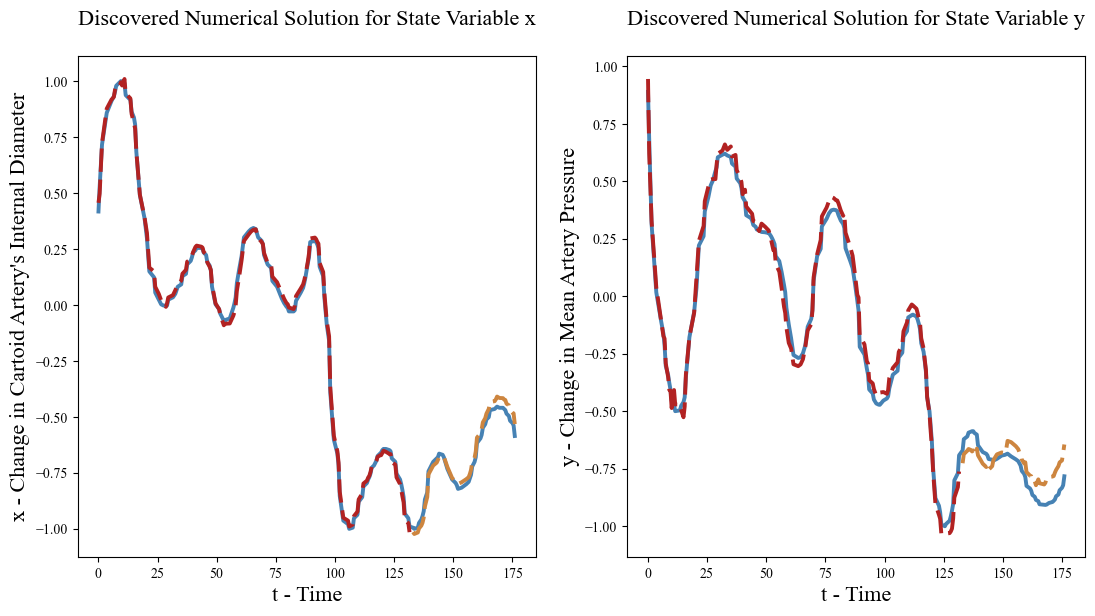

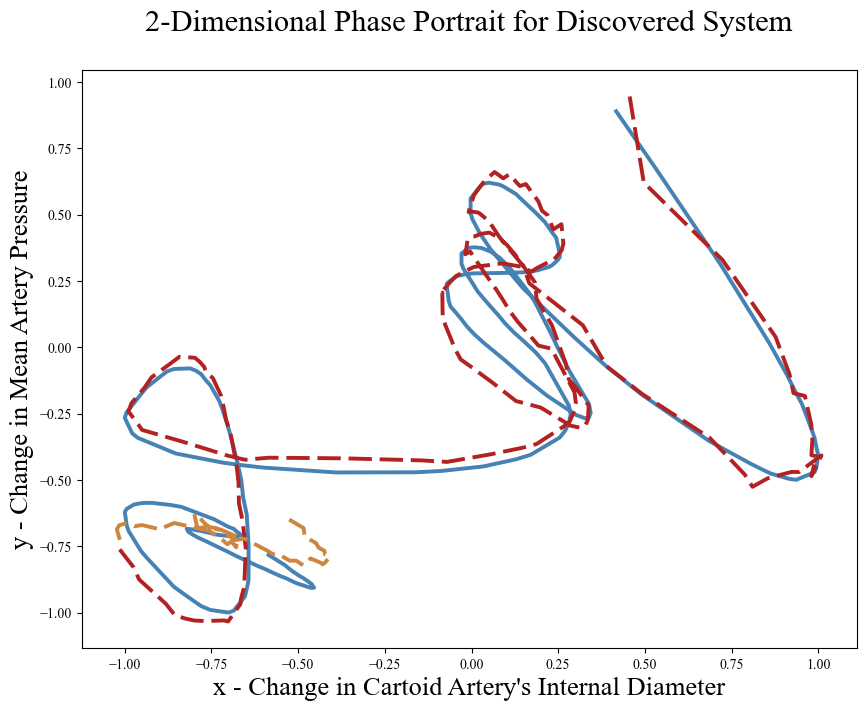

grad4q -0.10495805269104519
sIt: 0, Loss: 3.1859851442e-03, Time: 2164.05
0.05
0.32064531560476695


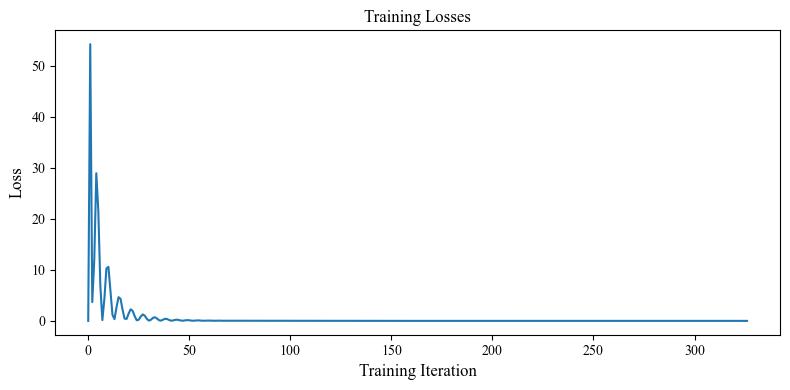

In [40]:
for it in range(1):
    # Y_pred =   # S x N x D
    # appx = calappx(NN, q, 0.01, realData, NX)
    appx, grad4q = calappx(NN, q, realt, realData, N, NX, NVar)
    print("grad4q", grad4q)
    loss = torch.sum(torch.square(appx)) / NX
    optimizer_Adam.zero_grad()
    loss.backward(retain_graph=True)
    l = loss.item()
    if l < lossmin:
        lossmin = l
        torch.save(NN.state_dict(), r'C:\Users\Admin\Desktop\NN Discovery\code\Frac_NN_alpha_min_duffing.pkl')
        torch.save(q, r'C:\Users\Admin\Desktop\NN Discovery\code\q_value_min_duffing.pth')

    optimizer_Adam.step()
    learning_rate4q = np.power(10, -np.ceil(np.log10(abs(grad4q))) - 3)
    q = q - learning_rate4q * grad4q
    if q < 0:
        q = 0.0001
    if q > 1:
        q = 0.9999

    q_value.append(q)

    # scheduler.step()
    # logging.info(loss.item())
    if it % 1 == 0:
        losses.append(loss.item())
        elapsed = timeit.default_timer() - start_time
        print('sIt: %d, Loss: %.10e, Time: %.2f' %(it, loss.item(), elapsed))
        print(optimizer_Adam.state_dict()['param_groups'][0]['lr'])
        print(q)

        torch.save(NN.state_dict(), r'C:\Users\Admin\Desktop\NN Discovery\code\Frac_NN_alpha_duffing.pkl')
        torch.save(q_value, r'C:\Users\Admin\Desktop\NN Discovery\code\q_value_duffing.pth')
        start_time = timeit.default_timer()
        
    if it % 5 == 0:
        plt.figure(figsize=(8, 4))
        plt.plot(range(len(losses)), losses)
        plt.xlabel('Training Iteration', fontname='Times New Roman', fontsize=12)
        plt.ylabel('Loss', fontname='Times New Roman', fontsize=12)
        plt.title('Training Losses', fontname='Times New Roman', fontsize=12)
        
        plt.tight_layout()
        plt.show()

In [27]:
plt.rcParams['font.family'] = 'Times New Roman'